In [1]:
install.packages("gridExtra")

Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)



In [2]:
library(ggplot2)
library(cowplot)
library(ranger)
library(Metrics)
library(latex2exp)
library(reshape2)
library(akima)
library(pander)
library(gridExtra)
library(repr)
library(dplyr)
options(repr.plot.width=22, repr.plot.height=16)
theme_update(text = element_text(size=20))
seeeed = 0


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************



Attaching package: 'dplyr'


The following object is masked from 'package:gridExtra':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [3]:
# Function to compute the percentage error of the prediction
getAccuracy <- function(p) {
    construct_percent_matrix <- function(data){
        x <- data
        m <- length(unique(x$kernel))
        n <- length(unique(x$device))
        y <- matrix(nrow=m,ncol=n,dimnames = list(unique(x$kernel),unique(x$device)))

        m_c <- 1
        for (i in unique(x$kernel)){
            n_c <- 1
            for (j in unique(x$device)){
                pred <- mean(subset(x,kernel==i&device==j)$predicted)
                meas <- mean(subset(x,kernel==i&device==j)$actual)
                y[m_c,n_c] <- abs(pred - meas) / meas * 100
                n_c <- n_c + 1
            }
            m_c <- m_c + 1
        }
        return (y)
    }

    z <- p
    total_percent <- data.frame()

    for(sz in c('tiny','small','medium','large')){
        x <- subset(z,size==sz)
        hm_z <- construct_percent_matrix(x)
        my <- melt(hm_z)
        total_percent <- rbind(total_percent,my)

        assign(paste('my_',sz,sep=''),my)
    }

    total_percent = na.omit(total_percent)
    return (100 - mean(total_percent$value))
}

In [4]:
# Function to compute the percentage error of the prediction
getAccuracyIndiv <- function(p) {
    construct_percent_matrix <- function(data){
        x <- data
        m <- length(unique(x$kernel))
        n <- length(unique(x$device))
        y <- matrix(nrow=m,ncol=n,dimnames = list(unique(x$kernel),unique(x$device)))

        m_c <- 1
        for (i in unique(x$kernel)){
            n_c <- 1
            for (j in unique(x$device)){
                pred <- mean(subset(x,kernel==i&device==j)$predicted)
                meas <- mean(subset(x,kernel==i&device==j)$actual)
                y[m_c,n_c] <- abs(pred - meas) / meas * 100
                n_c <- n_c + 1
            }
            m_c <- m_c + 1
        }
        return (y)
    }

    z <- p
    total_percent <- data.frame()

    for(sz in c('tiny','small','medium','large')){
        x <- subset(z,size==sz)
        hm_z <- construct_percent_matrix(x)
        my <- melt(hm_z)
        total_percent <- rbind(total_percent,my)

        assign(paste('my_',sz,sep=''),my)
    }

    total_percent = na.omit(total_percent)
    return (total_percent)
}

In [5]:
trainModelGetAccuracy <- function(tr_dat, ts_dat, nt, mt, mns) {
    set.seed(seeeed)
    
    tr_dat = subset(tr_dat, select = -size)
    tr_dat = subset(tr_dat, select = -kernel)
    tr_dat = subset(tr_dat, select = -total_time)
    
    rgd.aiwc <- ranger(log(kernel_time)~.,
                   data = tr_dat,
                   num.trees = nt,
                   mtry = mt,
                   min.node.size = mns,
                   importance = "impurity",
                   splitrule = 'variance',
                   respect.unordered.factors = 'order')

    #make the predictions
    rgd.pred <- predict(rgd.aiwc,type='response',data=ts_dat)

    z <- data.frame(predicted=rgd.pred$predictions,
                    actual=log(ts_dat$kernel_time),
                    device=ts_dat$device,
                    size=ts_dat$size,
                    kernel=ts_dat$kernel)
    
    return (getAccuracy(z))
}

In [6]:
trainModelGetAccuracySearch <- function(tr_dat, ts_dat, nt, mt, mns, rep, imp, srul) {
#     set.seed(seeeed)
    
    tr_dat = subset(tr_dat, select = -size)
    tr_dat = subset(tr_dat, select = -kernel)
    tr_dat = subset(tr_dat, select = -total_time)
    
    rgd.aiwc <- ranger(log(kernel_time)~.,
                           data = tr_dat,
                           num.trees = nt,
                           mtry = mt,
                           min.node.size = mns,
                           replace = rep,
                           importance = imp,
                           splitrule = srul,
                           respect.unordered.factors = 'order')

    #make the predictions
    rgd.pred <- predict(rgd.aiwc,type='response',data=ts_dat)

    z <- data.frame(predicted=rgd.pred$predictions,
                    actual=log(ts_dat$kernel_time),
                    device=ts_dat$device,
                    size=ts_dat$size,
                    kernel=ts_dat$kernel)
    
    return (getAccuracy(z))
}

In [7]:
leaveOneKernelAccuracySearch <- function(dat, nt, mt, mns, rep, imp, srul) {
    accuracies = c()
    zMatrices <- c()
    accs = c()

    for (unique_kern in unique(dat$kernel)) {

        train_dat <- dat[!(dat$kernel %in% unique_kern), ]
        train_dat = subset(train_dat, select = -size)
#         train_dat = subset(train_dat, select = -application)
        train_dat = subset(train_dat, select = -kernel)
        train_dat = subset(train_dat, select = -total_time)
    #     train_dat = subset(train_dat, select = -run)
#         train_dat = subset(train_dat, select = -invocation)

        test_dat = dat[dat$kernel %in% unique_kern, ]

        #build the model
        rgd.aiwc <- ranger(log(kernel_time)~.,
                           data = train_dat,
                           num.trees = nt,
                           mtry = mt,
                           min.node.size = mns,
                           replace = rep,
                           importance = imp,
                           splitrule = srul,
                           respect.unordered.factors = 'order')

        #make the predictions
        rgd.pred <- predict(rgd.aiwc,type='response',data=test_dat)

        z <- data.frame(predicted=rgd.pred$predictions,
                        actual=log(test_dat$kernel_time),
                        device=test_dat$device,
                        size=test_dat$size,
                        kernel=test_dat$kernel)

        #plots the model of predicted vs measured run-times of all the kernels

        accuracies <- c(accuracies, getAccuracy(z))
    }

    return (accuracies)
}

In [8]:
leaveOneKernelAccuracy <- function(dat, nt, mt, mid) {
    accuracies = c()
    zMatrices <- c()
    accs = c()

    for (unique_kern in unique(dat$kernel)) {

        train_dat <- dat[!(dat$kernel %in% unique_kern), ]
        train_dat = subset(train_dat, select = -size)
#         train_dat = subset(train_dat, select = -application)
        train_dat = subset(train_dat, select = -kernel)
        train_dat = subset(train_dat, select = -total_time)
    #     train_dat = subset(train_dat, select = -run)
#         train_dat = subset(train_dat, select = -invocation)

        test_dat = dat[dat$kernel %in% unique_kern, ]

        #build the model
        rgd.aiwc <- ranger(log(kernel_time)~.,
                           data = train_dat,
                           num.trees = nt,
                           mtry = mt,
                           min.node.size = mid,
                           importance = "impurity",
                           splitrule = 'variance',
                           respect.unordered.factors = 'order')

        #make the predictions
        rgd.pred <- predict(rgd.aiwc,type='response',data=test_dat)

        z <- data.frame(predicted=rgd.pred$predictions,
                        actual=log(test_dat$kernel_time),
                        device=test_dat$device,
                        size=test_dat$size,
                        kernel=test_dat$kernel)

        #plots the model of predicted vs measured run-times of all the kernels

        accuracies <- c(accuracies, getAccuracy(z))
    }

    return (accuracies)
}

In [9]:
generateTable <- function(intput_dataset, eval_data_set, scale=FALSE, param_num_trees, param_mtry, param_min_node_size) { 
    
    if (missing(param_num_trees)) {
        param_num_trees = 505
    }
    if (missing(param_mtry)) {
        param_num_trees = 60
    }
    if (missing(param_min_node_size)) {
        param_num_trees = 20
    }
    
    intput_dataset = subset(intput_dataset, select = -size)
    intput_dataset = subset(intput_dataset, select = -kernel)
    intput_dataset = subset(intput_dataset, select = -total_time)
    
    set.seed(seeeed)
    tr_px_data <- intput_dataset
    ts_px_data <- eval_data_set

    rgd.aiwc <- ranger(log(kernel_time)~.,
                       data = tr_px_data,
                       num.trees = param_num_trees,
                       mtry = param_mtry,
                       min.node.size = param_min_node_size,
                       importance = "impurity",
                       splitrule = 'variance',
                       respect.unordered.factors = 'order')


    rgd.pred <- predict(rgd.aiwc,type='response',data=ts_px_data)

    z <- data.frame(predicted=rgd.pred$predictions,
                    actual=log(ts_px_data$kernel_time),
                    device=ts_px_data$device,
                    size=ts_px_data$size,
                    kernel=ts_px_data$kernel)
    z <- z[order(z$device), ]
    oz <- z

    construct_percent_matrix <- function(data){
        x <- data
        m <- length(unique(x$kernel))
        n <- length(unique(x$device))
        y <- matrix(nrow=m,ncol=n,dimnames = list(unique(x$kernel),unique(x$device)))

        m_c <- 1
        for (i in unique(x$kernel)){
            n_c <- 1
            for (j in unique(x$device)){
                pred <- mean(subset(x,kernel==i&device==j)$predicted)
                meas <- mean(subset(x,kernel==i&device==j)$actual)
                y[m_c,n_c] <- abs(pred - meas) / meas * 100
                n_c <- n_c + 1
            }
            m_c <- m_c + 1
        }
        return (y)
    }

    total_percent <- data.frame()

    for(sz in c('tiny','small','medium','large')){
        x <- subset(z,size==sz)
        hm_z <- construct_percent_matrix(x)
        my <- melt(hm_z)
        total_percent <- rbind(total_percent,my)

        #dirty hack to get plots the same size -- some label lengths are different so just get one label in the bottom plots to be as long
        #library(stringi)
        #max(stri_length(total_percent$Var1))
        ##30 is the longest string
        my$Var1 <- as.character(my$Var1)
        if(sz %in% c('tiny','medium'))
            my$Var1[which(my$Var1=="needle_opencl_shared_2")] <- "        needle_opencl_shared_2"
        else
            my$Var1[which(my$Var1=="needle_opencl_shared_2")] <- "needle_opencl_shared_2        "
        my$Var1 <- as.factor(my$Var1)

        assign(paste('my_',sz,sep=''),my)
    }

    sc <- max(total_percent$value)
    if (scale) {
        sc <- 20
    }
    
    
    for(sz in c('tiny','small','medium','large')){
        my <- eval(parse(text=paste('my_',sz,sep='')))
        p <- ggplot(data=my,aes(y=Var1,x=Var2,fill=value,label=value))
        p <- p + geom_tile()
        p <- p + scale_fill_continuous(high = "black", low = "white",limits=c(0, sc))
        p <- p + labs(x='device',y='kernel',fill=TeX('prediction error ($\\%$)'))
        p <- p + theme(legend.position = "none",
                       axis.text.x = element_text(size = 8),
                       axis.text.y = element_text(size = 8,angle=45),
                       axis.title.x = element_text(size=10),
                       axis.title.y = element_text(size=10))

        if(sz == 'tiny')
            p <- p + scale_x_discrete(position = 'top') + theme(axis.text.x = element_text(angle = 45, hjust = 0, vjust=0))
        if(sz == 'small')
            p <- p + scale_y_discrete(position = 'right') + scale_x_discrete(position = 'top') + theme(axis.text.x = element_text(angle = 45, hjust = 0, vjust=0))
        if(sz == 'medium')
            p <- p + scale_y_discrete(position = 'left') + scale_x_discrete(position = 'bottom') + theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust=1))
        if(sz == 'large')
            p <- p + scale_y_discrete(position = 'right') + scale_x_discrete(position = 'bottom') + theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust=1))

        assign(paste('stacked_',sz,sep=''),p)
    }

    legend_generic <- get_legend(stacked_tiny + theme(legend.title=element_text(face="bold",size=10),
                                                      legend.text=element_text(size=10),
                                                      legend.position="bottom",
                                                      legend.justification="right",
                                                      legend.direction="horizontal"))
    plots <- align_plots(stacked_tiny  ,
                         stacked_small ,
                         stacked_medium,
                         stacked_large)
                         #align="hv",axis="tblr")

    xoff <- .22 # relative x position of label, within one plot
    yoff <- .98 # relative y position of label, within one plot

    xx2 <- plot_grid(plot_grid(plots[[1]],plots[[2]],ncol=2,align="h")+draw_plot_label(label=c("Tiny",  "Small"),
                                                                                     x=c(0.22,0.55),
                                                                                     y=rep(1-(1-yoff),2),
                                                                                     hjust=.5, vjust=.5,
                                                                                     size=14),
                   plot_grid(plots[[3]],plots[[4]],ncol=2,align="h")+draw_plot_label(label=c("       Medium",  "Large"),
                                                                                     x=c(0.22,0.55),
                                                                                     y=c(0.985,0.985),
                                                                                     hjust=.5, vjust=.5,
                                                                                     size=14),
                   legend_generic,
                   rel_heights=c(1,1,.065),
                   nrow=3)
    
    total_percent = na.omit(total_percent)
    
    print(paste("Mean prediction error:",mean(total_percent$value),"%"))
    
    print(paste("Average prediction accuracy = ",100-mean(total_percent$value),"%"))

    print(paste("min execution time mispredictions (us): ",round(min(intput_dataset$kernel_time)* round(mean(total_percent$value),1))))

    print(paste("min execution time mispredictions (ms): ",round(max(intput_dataset$kernel_time)* round(mean(total_percent$value),1))*10**-3))
    return (xx2)
}

<h1> Previous Findings </h1>

In this section we consider the results from the paper <a href='https://arxiv.org/abs/1811.00156'>"OpenCL Predictions using Architecture Independent Features"</a>.

We first replicate the findings using the original code and dataset provided by the paper artefact.

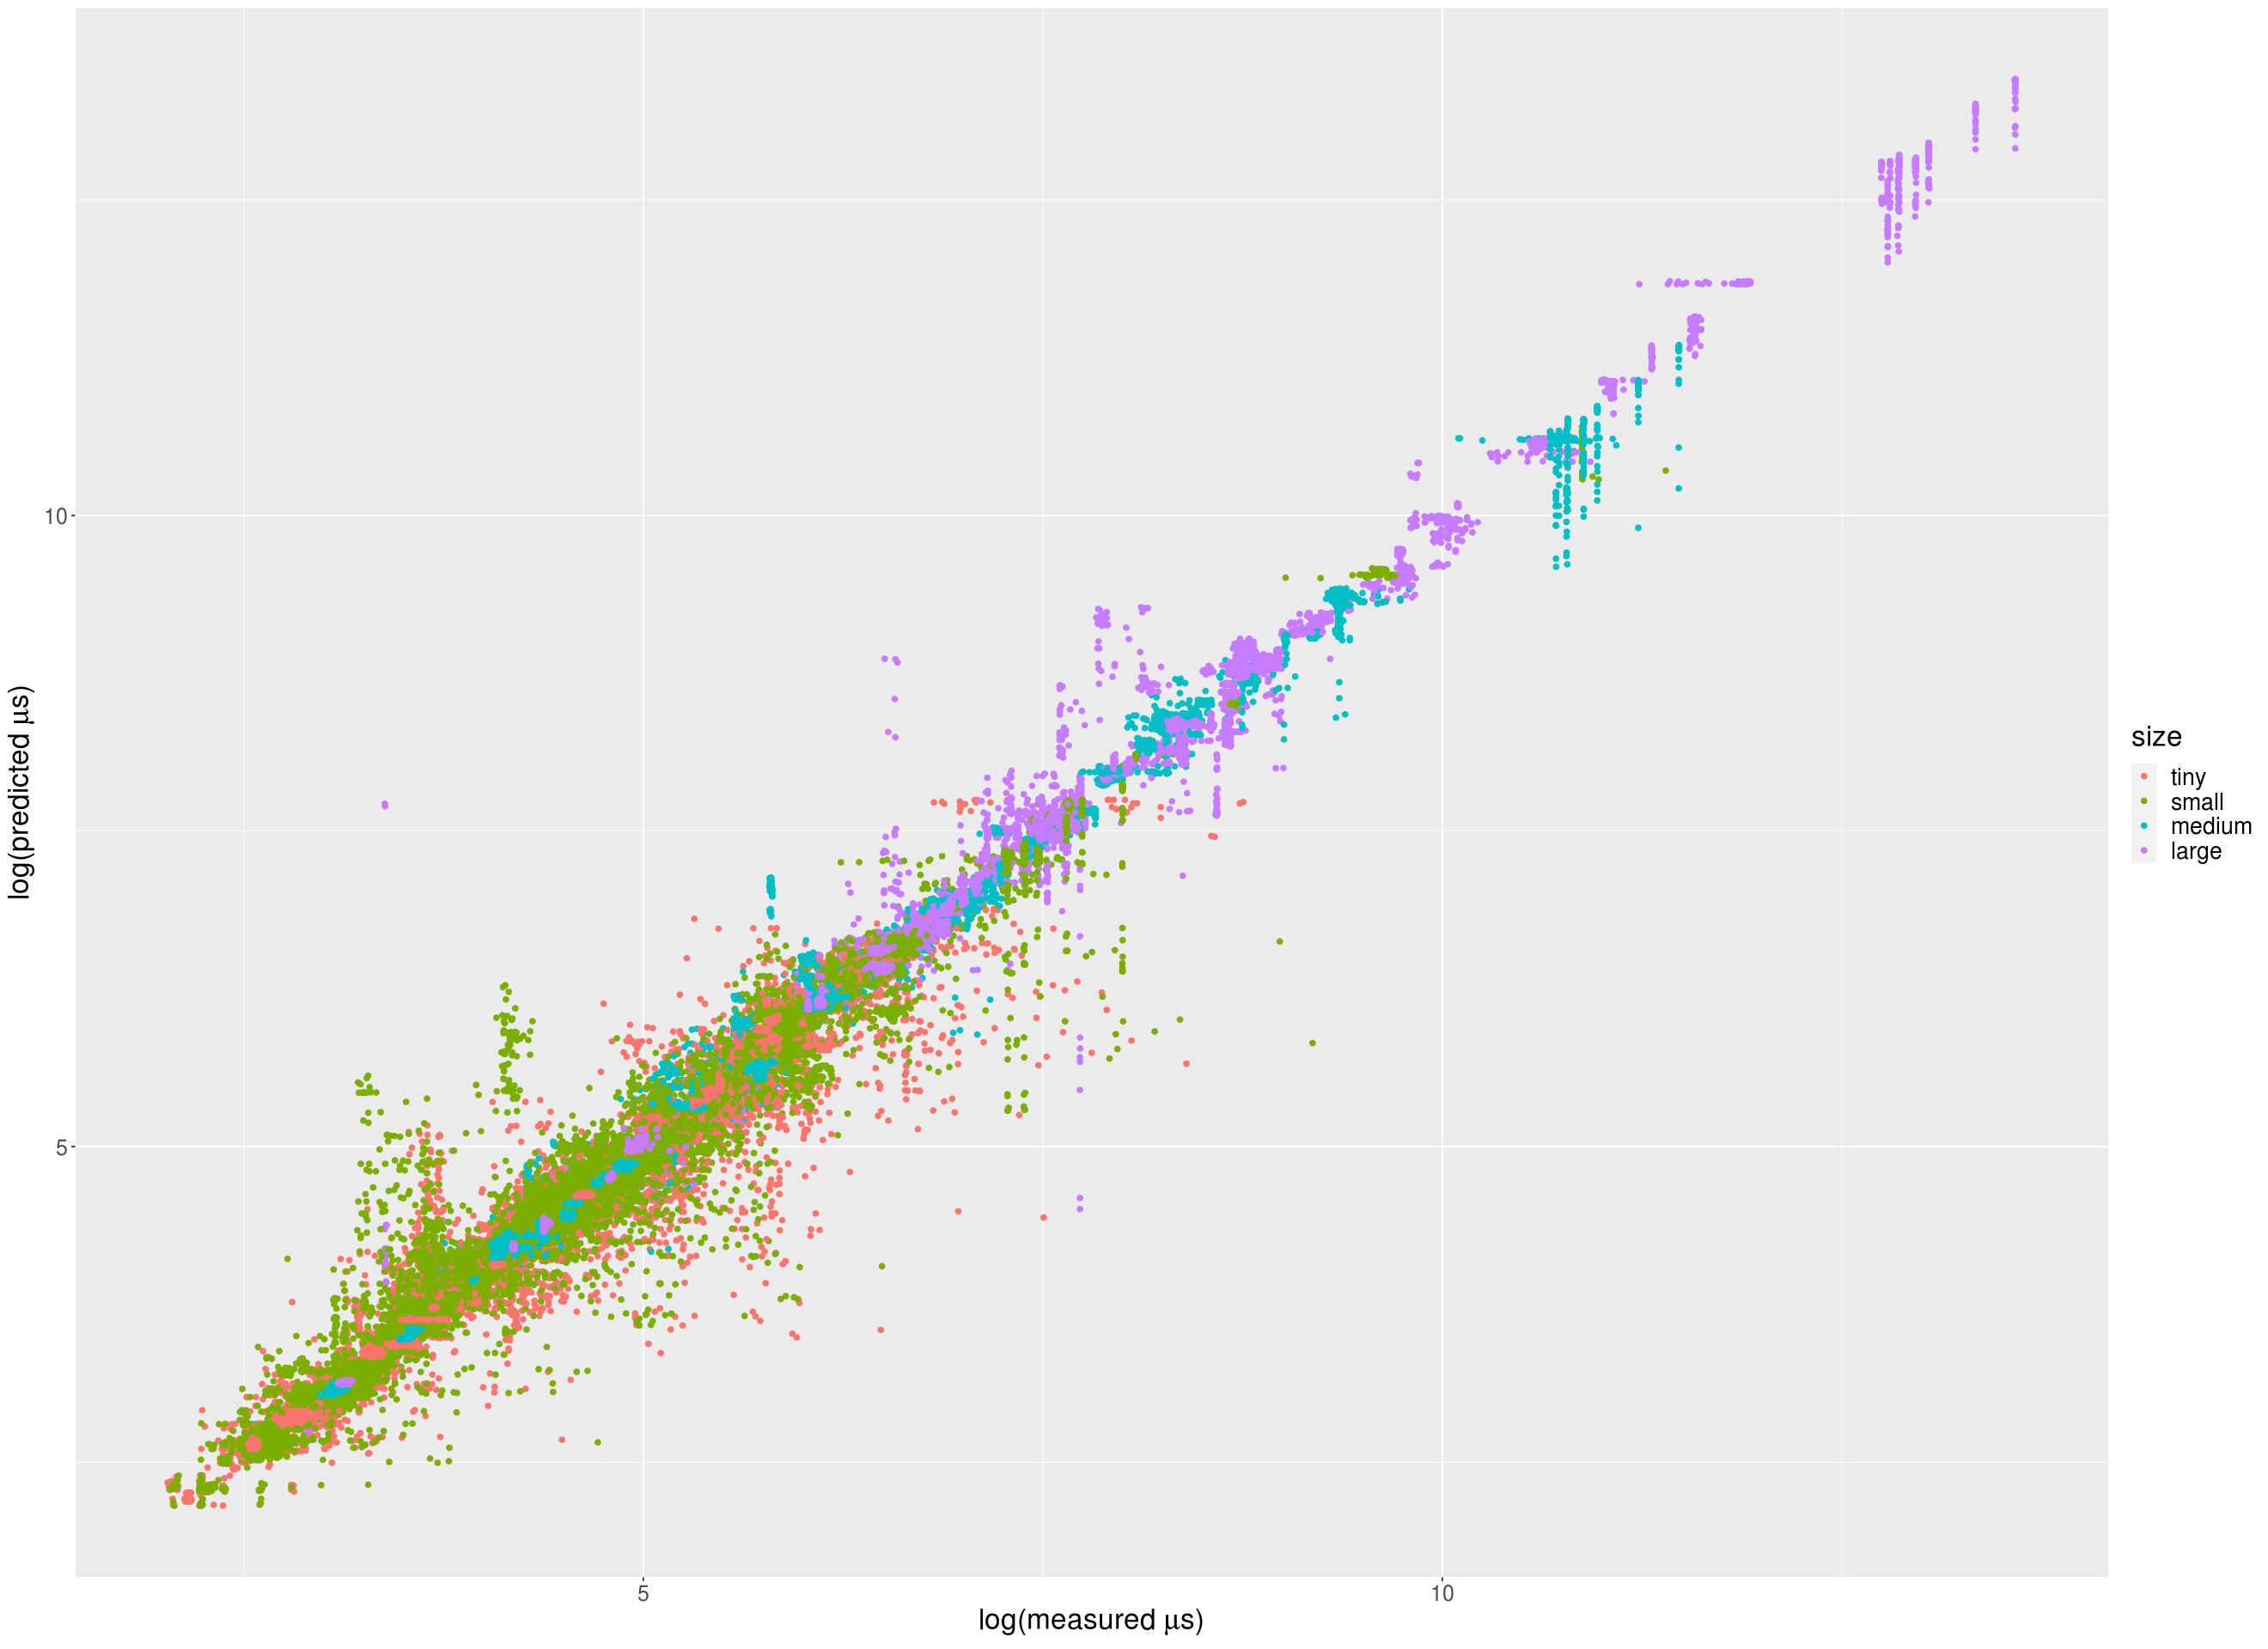

In [10]:
#generated with ../analysis_tools/sample_generator.R
load("full_dat.Rda")
# full_dat = rbind(full_dat, p100data, golddata, goldinvocationdata) #, testing)
full_dat <- na.omit(full_dat)

#manually typecast integer variables
int.inds <- c(2,6,7,8,9,10,11,12,13,16,17,29,30,34,37)

#standardise numeric variables
num.inds <- lapply(full_dat, is.numeric)
num.inds <- as.logical(num.inds)

for (i in seq(along = num.inds)){
            feature.name = names(full_dat[i])
            ifelse((any(i == int.inds) || num.inds[i] == 'FALSE' || feature.name == "kernel_time"), next, full_dat[i] <- scale(full_dat[i]))
                                } #end i loop

#use 20% of data for training
sampled_indices <- sample(seq_len(nrow(full_dat)), size = round(nrow(full_dat)*0.2))
train_dat <- full_dat[sampled_indices, ]
test_dat <- full_dat[-sampled_indices, ]

#remove certain variables unavailable during real-world training
train_dat = subset(train_dat, select = -size)
train_dat = subset(train_dat, select = -application)
train_dat = subset(train_dat, select = -kernel)
train_dat = subset(train_dat, select = -total_time)

#build the model
rgd.aiwc <- ranger(log(kernel_time)~.,
                   data = train_dat,
                   num.trees = 505,
                   mtry = 30,
                   min.node.size = 9,
                   importance = "impurity",
                   splitrule = 'variance',
                   respect.unordered.factors = 'order')

#make the predictions
rgd.pred <- predict(rgd.aiwc,type='response',data=test_dat)

#plot the error
z <- data.frame(predicted=rgd.pred$predictions,
                actual=log(test_dat$kernel_time),
                device=test_dat$device,
                size=test_dat$size,
                kernel=test_dat$kernel)

#plot the difference in log(times)
ggplot(data=z,aes(x=actual,y=predicted,colour=size)) + geom_point() + labs(x=TeX("log(measured $\\mu$s)"),y=TeX("log(predicted $\\mu$s)"))+ theme(text = element_text(size=20),axis.text.x = element_text(size=15),axis.text.y = element_text(size=15))

#plot the absolute difference in times -- but I'd prefer to show this in the next section
#ggplot(data=z,aes(x=exp(actual),y=exp(predicted),colour=size)) + geom_point() + labs(x="predicted (us)",y="measured (us)")

#back up the predictions for the remainder of the paper
oz <- z

[1] "Mean prediction error: 1.20466563719508 %"
[1] "Average prediction accuracy =  98.7953343628049 %"
[1] "min execution time mispredictions (us):  9"
[1] "min execution time mispredictions (ms):  956.518"


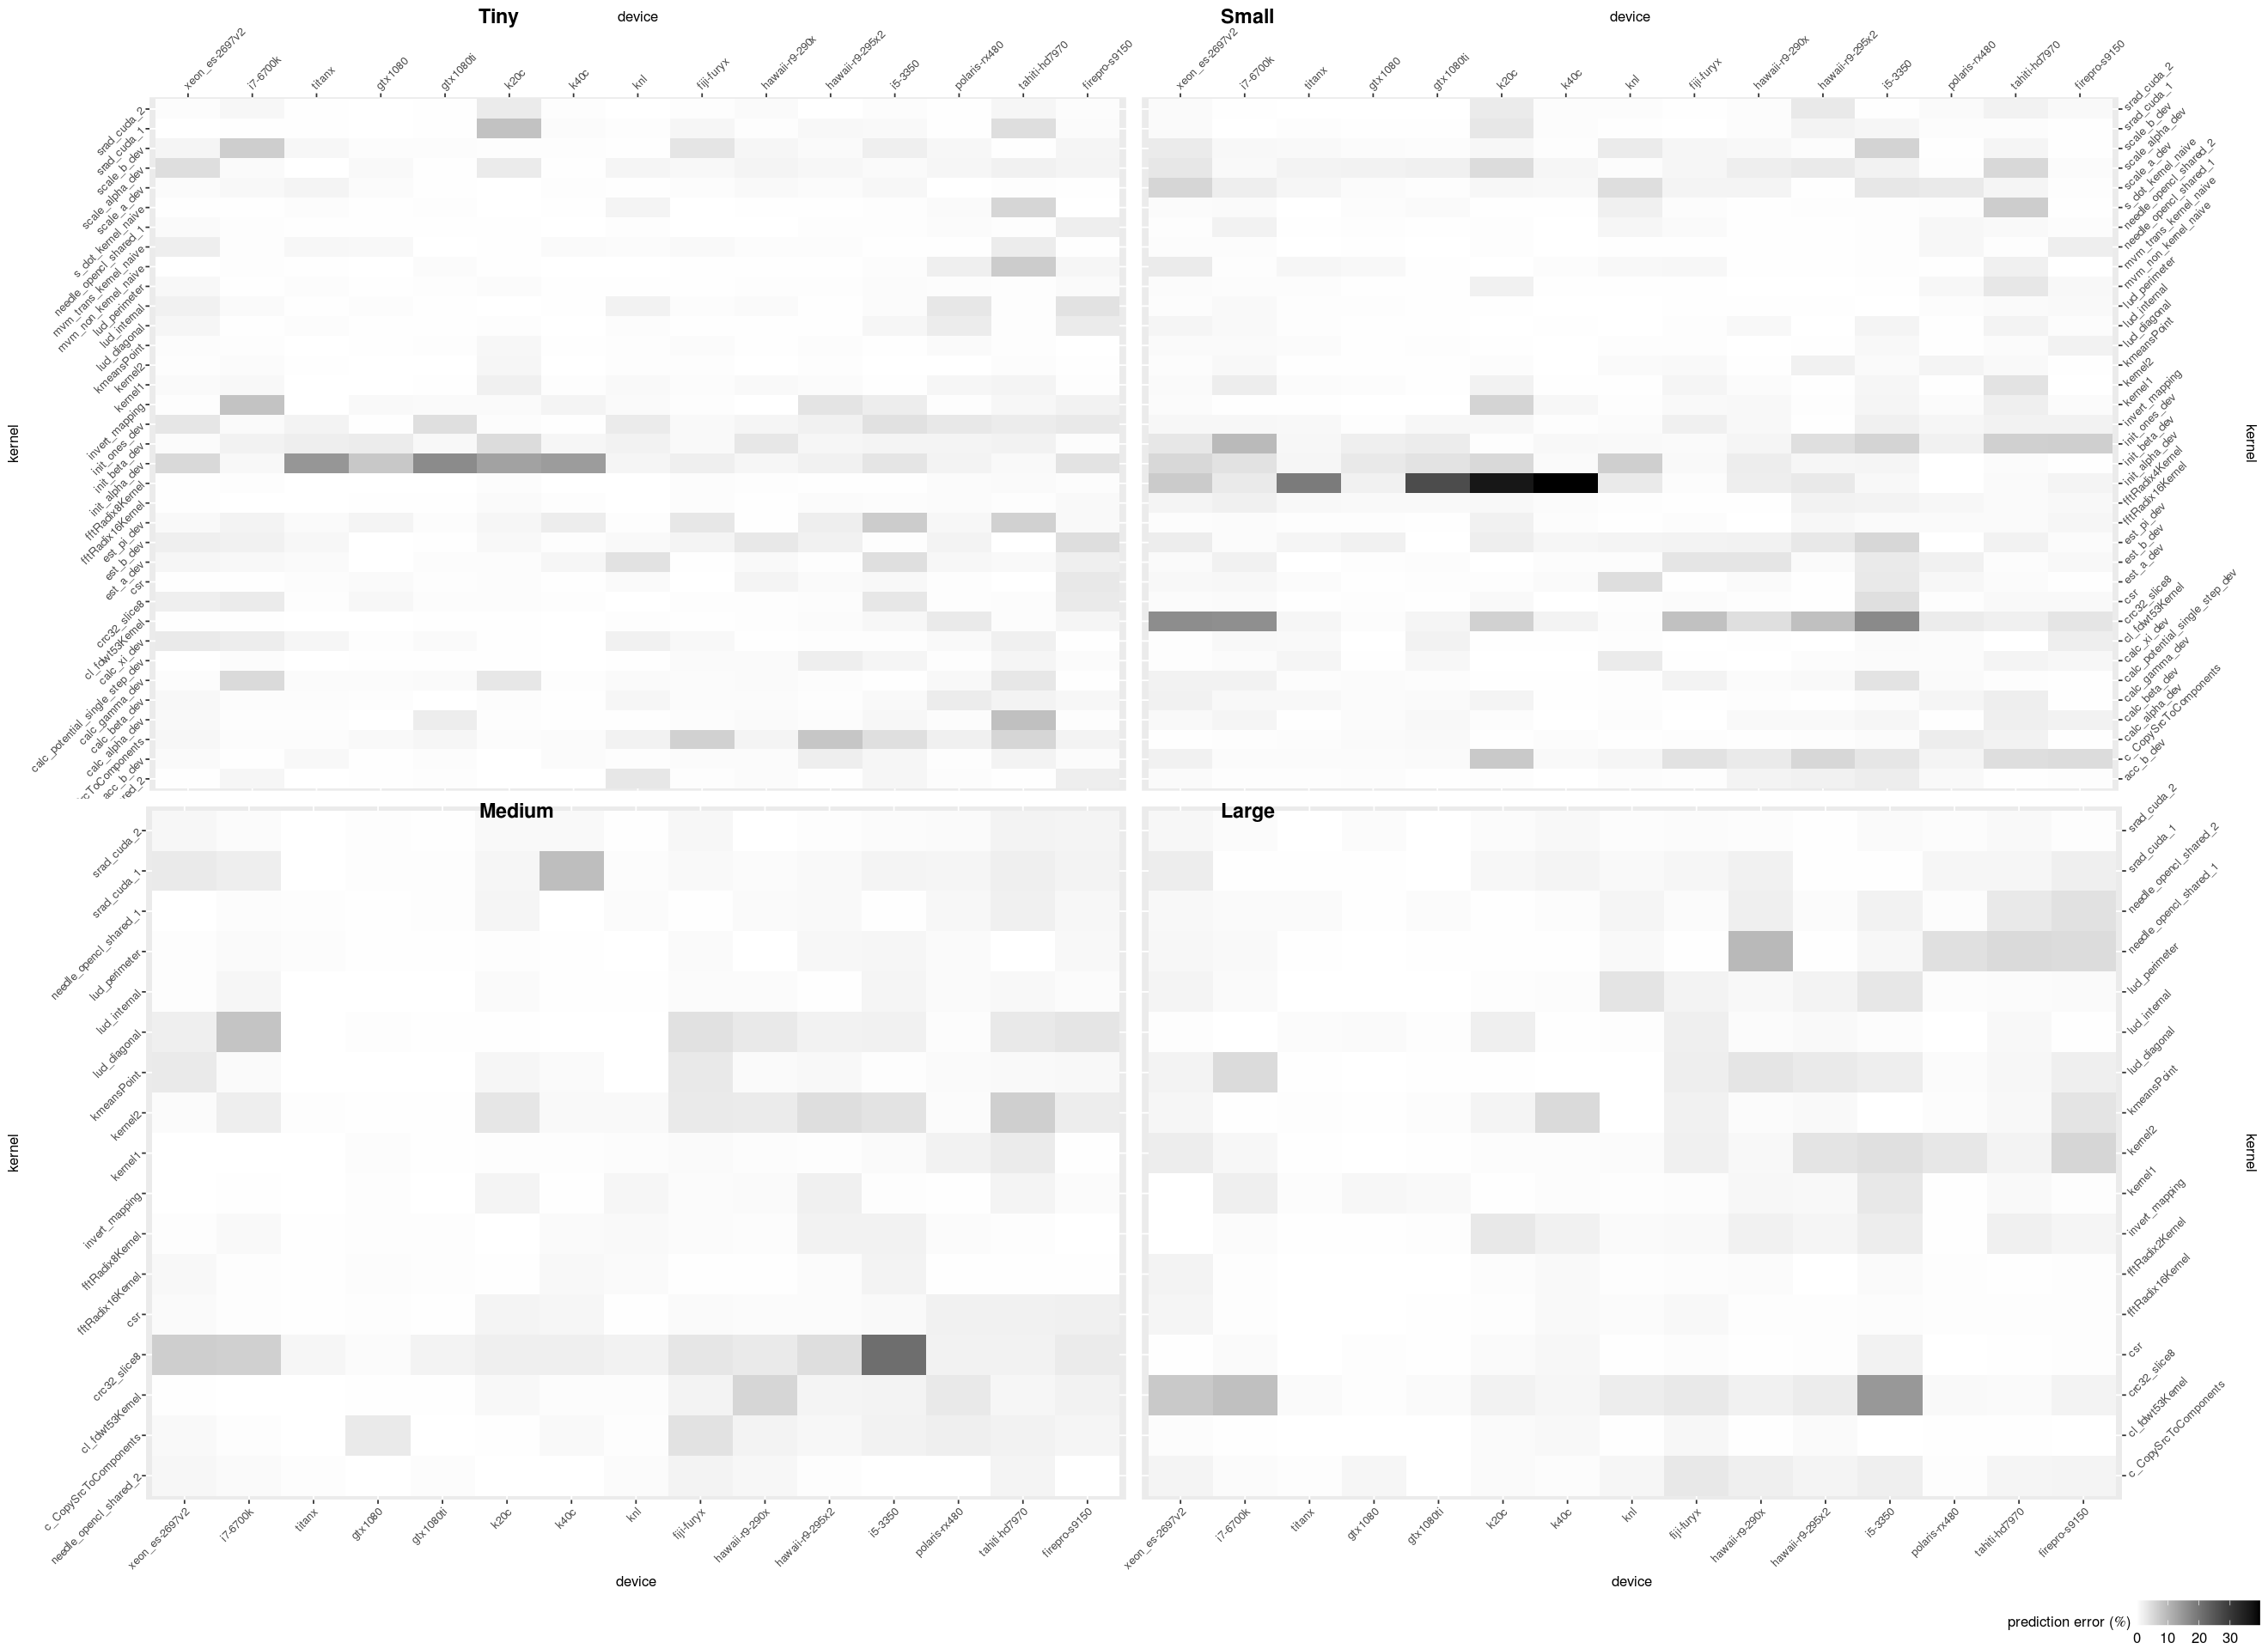

In [11]:
construct_percent_matrix <- function(data){
    x <- data
    m <- length(unique(x$kernel))
    n <- length(unique(x$device))
    y <- matrix(nrow=m,ncol=n,dimnames = list(unique(x$kernel),unique(x$device)))

    m_c <- 1
    for (i in unique(x$kernel)){
        n_c <- 1
        for (j in unique(x$device)){
            pred <- mean(subset(x,kernel==i&device==j)$predicted)
            meas <- mean(subset(x,kernel==i&device==j)$actual)
            y[m_c,n_c] <- abs(pred - meas) / meas * 100
            n_c <- n_c + 1
        }
        m_c <- m_c + 1
    }
    return (y)
}

z <- oz
total_percent <- data.frame()

for(sz in c('tiny','small','medium','large')){
    x <- subset(z,size==sz)
    hm_z <- construct_percent_matrix(x)
    my <- melt(hm_z)
    total_percent <- rbind(total_percent,my)

    #dirty hack to get plots the same size -- some label lengths are different so just get one label in the bottom plots to be as long
    #library(stringi)
    #max(stri_length(total_percent$Var1))
    ##30 is the longest string
    my$Var1 <- as.character(my$Var1)
    if(sz %in% c('tiny','medium'))
        my$Var1[which(my$Var1=="needle_opencl_shared_2")] <- "        needle_opencl_shared_2"
    else
        my$Var1[which(my$Var1=="needle_opencl_shared_2")] <- "needle_opencl_shared_2        "
    my$Var1 <- as.factor(my$Var1)

    assign(paste('my_',sz,sep=''),my)
}

for(sz in c('tiny','small','medium','large')){
    my <- eval(parse(text=paste('my_',sz,sep='')))
    p <- ggplot(data=my,aes(y=Var1,x=Var2,fill=value,label=value))
    p <- p + geom_tile()
    p <- p + scale_fill_continuous(high = "black", low = "white",limits=c(0, max(total_percent$value)))
    p <- p + labs(x='device',y='kernel',fill=TeX('prediction error ($\\%$)'))
    p <- p + theme(legend.position = "none",
                   axis.text.x = element_text(size = 8),
                   axis.text.y = element_text(size = 8,angle=45),
                   axis.title.x = element_text(size=10),
                   axis.title.y = element_text(size=10))

    if(sz == 'tiny')
        p <- p + scale_x_discrete(position = 'top') + theme(axis.text.x = element_text(angle = 45, hjust = 0, vjust=0))
    if(sz == 'small')
        p <- p + scale_y_discrete(position = 'right') + scale_x_discrete(position = 'top') + theme(axis.text.x = element_text(angle = 45, hjust = 0, vjust=0))
    if(sz == 'medium')
        p <- p + scale_y_discrete(position = 'left') + scale_x_discrete(position = 'bottom') + theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust=1))
    if(sz == 'large')
        p <- p + scale_y_discrete(position = 'right') + scale_x_discrete(position = 'bottom') + theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust=1))

    assign(paste('stacked_',sz,sep=''),p)
}

legend_generic <- get_legend(stacked_tiny + theme(legend.title=element_text(face="bold",size=10),
                                                  legend.text=element_text(size=10),
                                                  legend.position="bottom",
                                                  legend.justification="right",
                                                  legend.direction="horizontal"))
plots <- align_plots(stacked_tiny  ,
                     stacked_small ,
                     stacked_medium,
                     stacked_large)
                     #align="hv",axis="tblr")

xoff <- .22 # relative x position of label, within one plot
yoff <- .98 # relative y position of label, within one plot

x <- plot_grid(plot_grid(plots[[1]],plots[[2]],ncol=2,align="h")+draw_plot_label(label=c("Tiny",  "Small"),
                                                                                 x=c(0.22,0.55),
                                                                                 y=rep(1-(1-yoff),2),
                                                                                 hjust=.5, vjust=.5,
                                                                                 size=14),
               plot_grid(plots[[3]],plots[[4]],ncol=2,align="h")+draw_plot_label(label=c("       Medium",  "Large"),
                                                                                 x=c(0.22,0.55),
                                                                                 y=c(0.985,0.985),
                                                                                 hjust=.5, vjust=.5,
                                                                                 size=14),
               legend_generic,
               rel_heights=c(1,1,.065),
               nrow=3)
print(x)
total_percent = na.omit(total_percent)
print(paste("Mean prediction error:",mean(total_percent$value),"%"))
print(paste("Average prediction accuracy = ",100-mean(total_percent$value),"%"))

print(paste("min execution time mispredictions (us): ",round(min(full_dat$kernel_time)* round(mean(total_percent$value),1))))
print(paste("min execution time mispredictions (ms): ",round(max(full_dat$kernel_time)* round(mean(total_percent$value),1))*10**-3))

We verify that we can reproduce the results from the original paper, the predictice accuracy observed above corresponds to the 1.2% predictive error originally. We do however note that the original paper artefact did not provide a seed for their experiments so running the same code can result from anywhere between 1.8% to 0.9% predictive error (observed through empirical evaluation). 

<h2> 2. In this section we make some changes to the methodology set out previously and update our model relative to the new AIWC metrics </h2>
  
There are several ultimate uses we propose for our predictive model, for example:
<ul>
    <li> In high performance scheduling. Given data about all the kernels, provide the best ordering that optimises some criteria
    <li> In predicting the best device for a given workload. Given a new kernel we must be able to accurately model the best performing device it will run on.
</ul>
    
We propose that our model should not only have a high degree of accuracy on previously seen kernels but also a high degree of generalisability. To this extent we will use two metrics in order to evaluate any further predictive models. 

<ul>
    <li> (Leave-one-out) We will also use the leave-one-kernel out accuracy. This measures how well our model can generalise to previously completely unseen kernels.
    <li> (In-sample) We will use the previous evaluation methodology which involves segmenting the data into a 80% training and 20% testing set with no restrictions on kernels - this means that because we have 50 samples for each (kernel, size, device) pair then our model will likely have seen all (kernel, size, device) pairs in the training set.
</ul>

We see above that leave-one-out accuracy is 83.7% and from the previous section we have a ~1.2% in-sample predictive error.

We also take a look at the new features introduced into the AIWC framework by <a href="https://arxiv.org/abs/2003.06064">Characterizing Optimizations to Memory Access Patterns using Architecture-Independent Program Features"</a>. 

Using these new features we see that with the previous model parameters of 505, 30, 9 we see that the leave-one-out accuracy is 1.6% better than the old model at 85.3%. However the in-sample predictive accuracy is much worse at 3.36% error. We do a simple parameter search over num.trees, mtry and min.node.size for the parameters selected by the original paper - we choose these parameters because they were found originally to have a significant impact on the in-sample predictive accuracy. 
We do a search over each of these parameters and choose a new set of parameters that optimises both in-sample and leave-one-out accuracy to be num.trees = 100, mtry = 52 and min.node.size = 0. Using this new set of parameters we obtain a leave-one-out accuracy of 85.7% - a 2% improvement over the previous AIWC features. We also have reduced the in-sample predictive accuracy from 3.36% to 1.04%.


In [28]:
load("full_dat.Rda")
full_dat = subset(full_dat, select = -application)
mean_accs_old <- leaveOneKernelAccuracy(full_dat, 505, 30, 9)
print(paste("The mean leave-one-out accuracy using old AIWC features is:", mean(mean_accs_old)))

[1] "The mean leave-one-out accuracy using old AIWC features is: 83.7438273934281"


In [30]:
df_opendwarfs_abf <- read.csv("Data-Opendwarfs_on_devices/full_old_abff4149.csv")
df_opendwarfs_abf[is.na(df_opendwarfs_abf)] <- 0

df_opendwarfs_abf$application <- 0
loo_abf <- leaveOneKernelAccuracy(df_opendwarfs_abf, 505, 30, 9)
print(paste("The mean leave-one-out accuracy using new AIWC features is:", mean(loo_abf)))

[1] "The mean leave-one-out accuracy using new AIWC features is: 85.2833862242924"


In [31]:
df_opendwarfs_abf$application <- 0
loo_abf_final <- leaveOneKernelAccuracy(df_opendwarfs_abf, 505, 50, 50)
print(paste("The mean leave-one-out accuracy using new AIWC features is:", mean(loo_abf_final)))

[1] "The mean leave-one-out accuracy using new AIWC features is: 85.7727324122278"


[1] "Mean prediction error: 4.28734850883984 %"
[1] "Average prediction accuracy =  95.7126514911602 %"
[1] "min execution time mispredictions (us):  34"
[1] "min execution time mispredictions (ms):  3427.147"


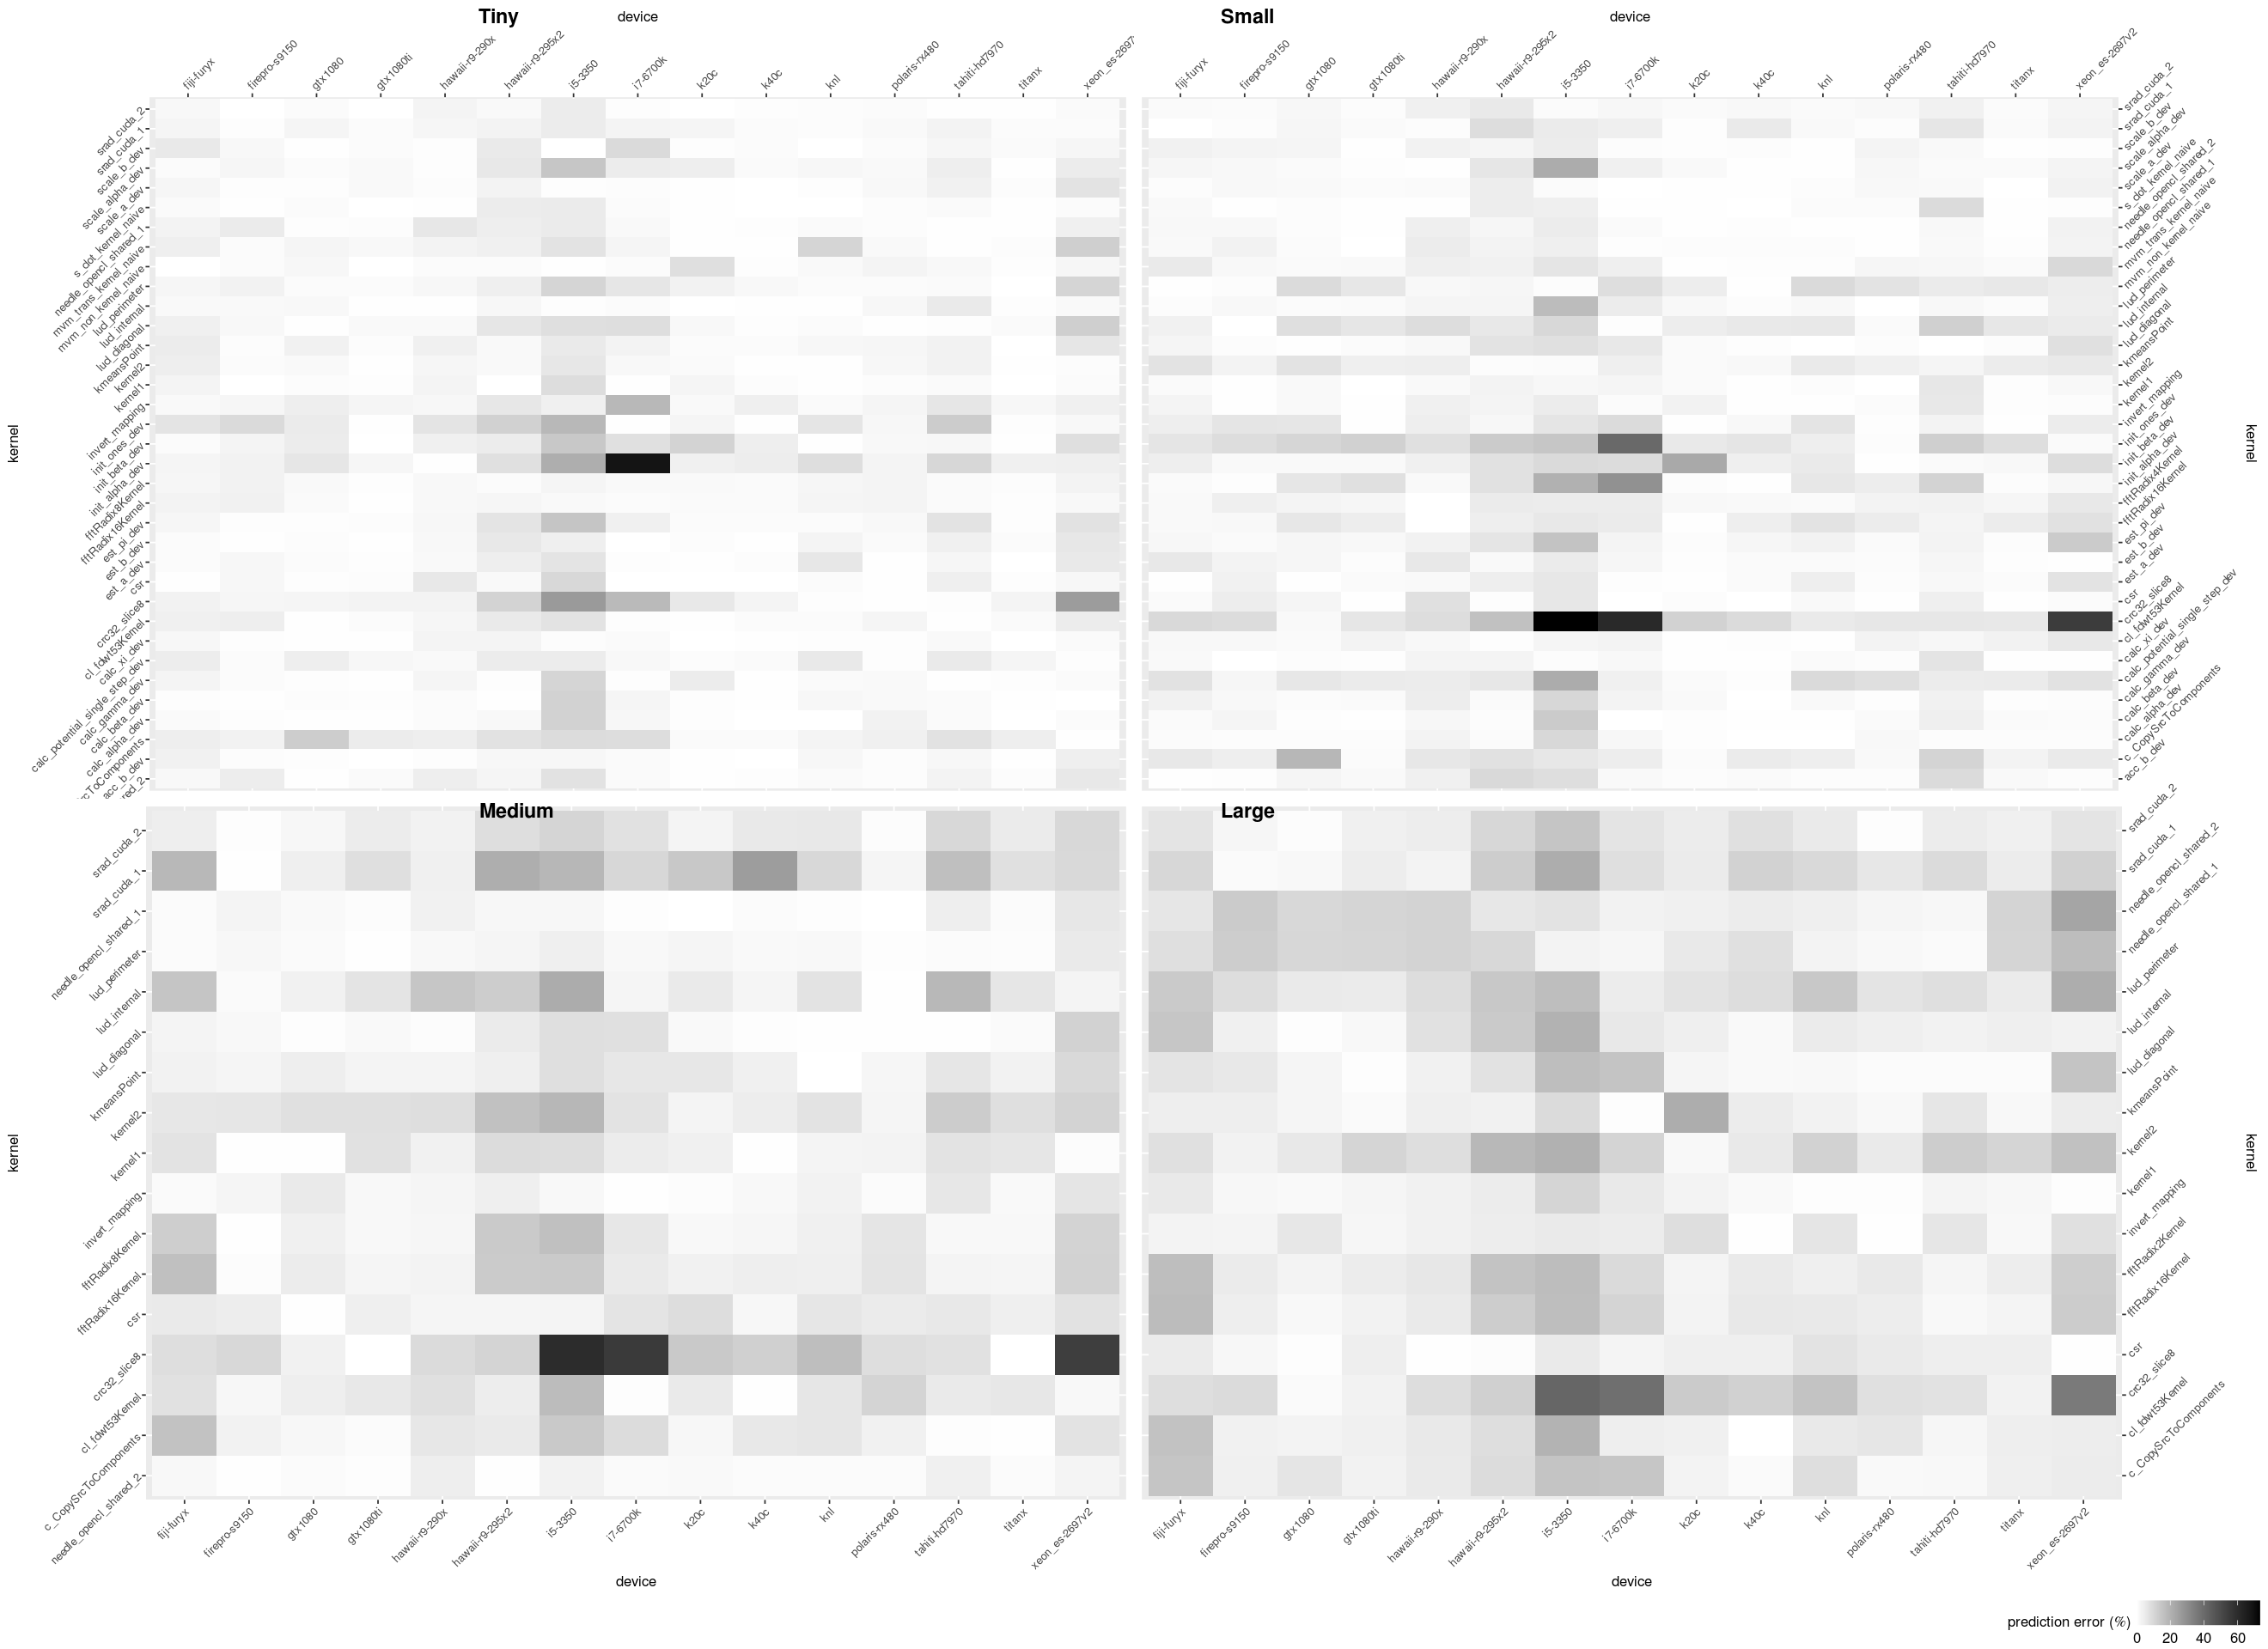

In [32]:
set.seed(seeeed)

#use 20% of data for training
sampled_indices <- sample(seq_len(nrow(df_opendwarfs_abf)), size = round(nrow(df_opendwarfs_abf)*0.2))
train_dat <- df_opendwarfs_abf[sampled_indices, ]
test_dat <- df_opendwarfs_abf[-sampled_indices, ]

#remove certain variables unavailable during real-world training
train_dat = subset(train_dat, select = -application)

generateTable(train_dat, test_dat, FALSE, 505, 30, 9)

In [16]:
# options(warn=-1)

# splitrules = c("variance", "extratrees", "maxstat")
# importances = c("none", "impurity", "permutation")
# replaces = c(TRUE, FALSE)

# params = data.frame(mtry=c(1),
#                     mns=c(1),
#                     srul=c(1),
#                     imp=c(1),
#                     rep=c(1),
#                     acc=c(1),
#                     insamp=c(1))


# sampled_indices <- sample(seq_len(nrow(df_opendwarfs_abf)), size = round(nrow(df_opendwarfs_abf)*0.8))
# train_set <- df_opendwarfs_abf[sampled_indices,]
# test_set <- df_opendwarfs_abf[-sampled_indices,]

# train_set = subset(train_set, select = -application)

# for (searchNo in seq(1:50)) {

#     mt_r = ceiling(runif(1) * 64)
#     mns_r = ceiling(runif(1) * 50)
#     rep_r = replaces[ceiling(runif(1) * 2)]
#     srul_r = splitrules[ceiling(runif(1) * 3)]
#     imp_r = importances[ceiling(runif(1) * 3)]

#     accracy = leaveOneKernelAccuracySearch(df_opendwarfs_abf, 1000, mt_r, mns_r, rep_r, imp_r, srul_r)
    
#     insampacc = trainModelGetAccuracySearch(train_set, test_set, 1000, mt_r, mns_r, rep_r, imp_r, srul_r)
    
#     param_stats = c(mt_r, mns_r, srul_r, imp_r, rep_r, mean(accracy), insampacc)
    
#     params = rbind(params, param_stats)
# }

In [17]:
# options(warn=-1)

params = data.frame(mtry=c(1),
                    mns=c(1),
                    acc=c(1),
                    insamp=c(1))


# sampled_indices <- sample(seq_len(nrow(df_opendwarfs_abf)), size = round(nrow(df_opendwarfs_abf)*0.8))
# train_set <- df_opendwarfs_abf[sampled_indices,]
# test_set <- df_opendwarfs_abf[-sampled_indices,]

# train_set = subset(train_set, select = -application)

# for (mns_r in seq(0, 50, 5)) {
    
#     for (mt_r in seq(10, 64, 4)) {

#         accracy = 1 # leaveOneKernelAccuracy(df_opendwarfs_abf, 1000, mt_r, mns_r)

#         insampacc = trainModelGetAccuracy(train_set, test_set, 1000, mt_r, mns_r)

#         param_stats = c(mt_r, mns_r, mean(accracy), insampacc)

#         params = rbind(params, param_stats)
        
#     }
# }

In [19]:
params = read.csv("Data-General_files/params.csv")
params = params[-1,]
v <- tail(params$insamp, length(params$insamp) )

params$insamp <- v

p <- params[-1,]


p$acc <- p$acc - min(p$acc)
p$acc <- p$acc / max(p$acc)

p$accuracy <- p$acc

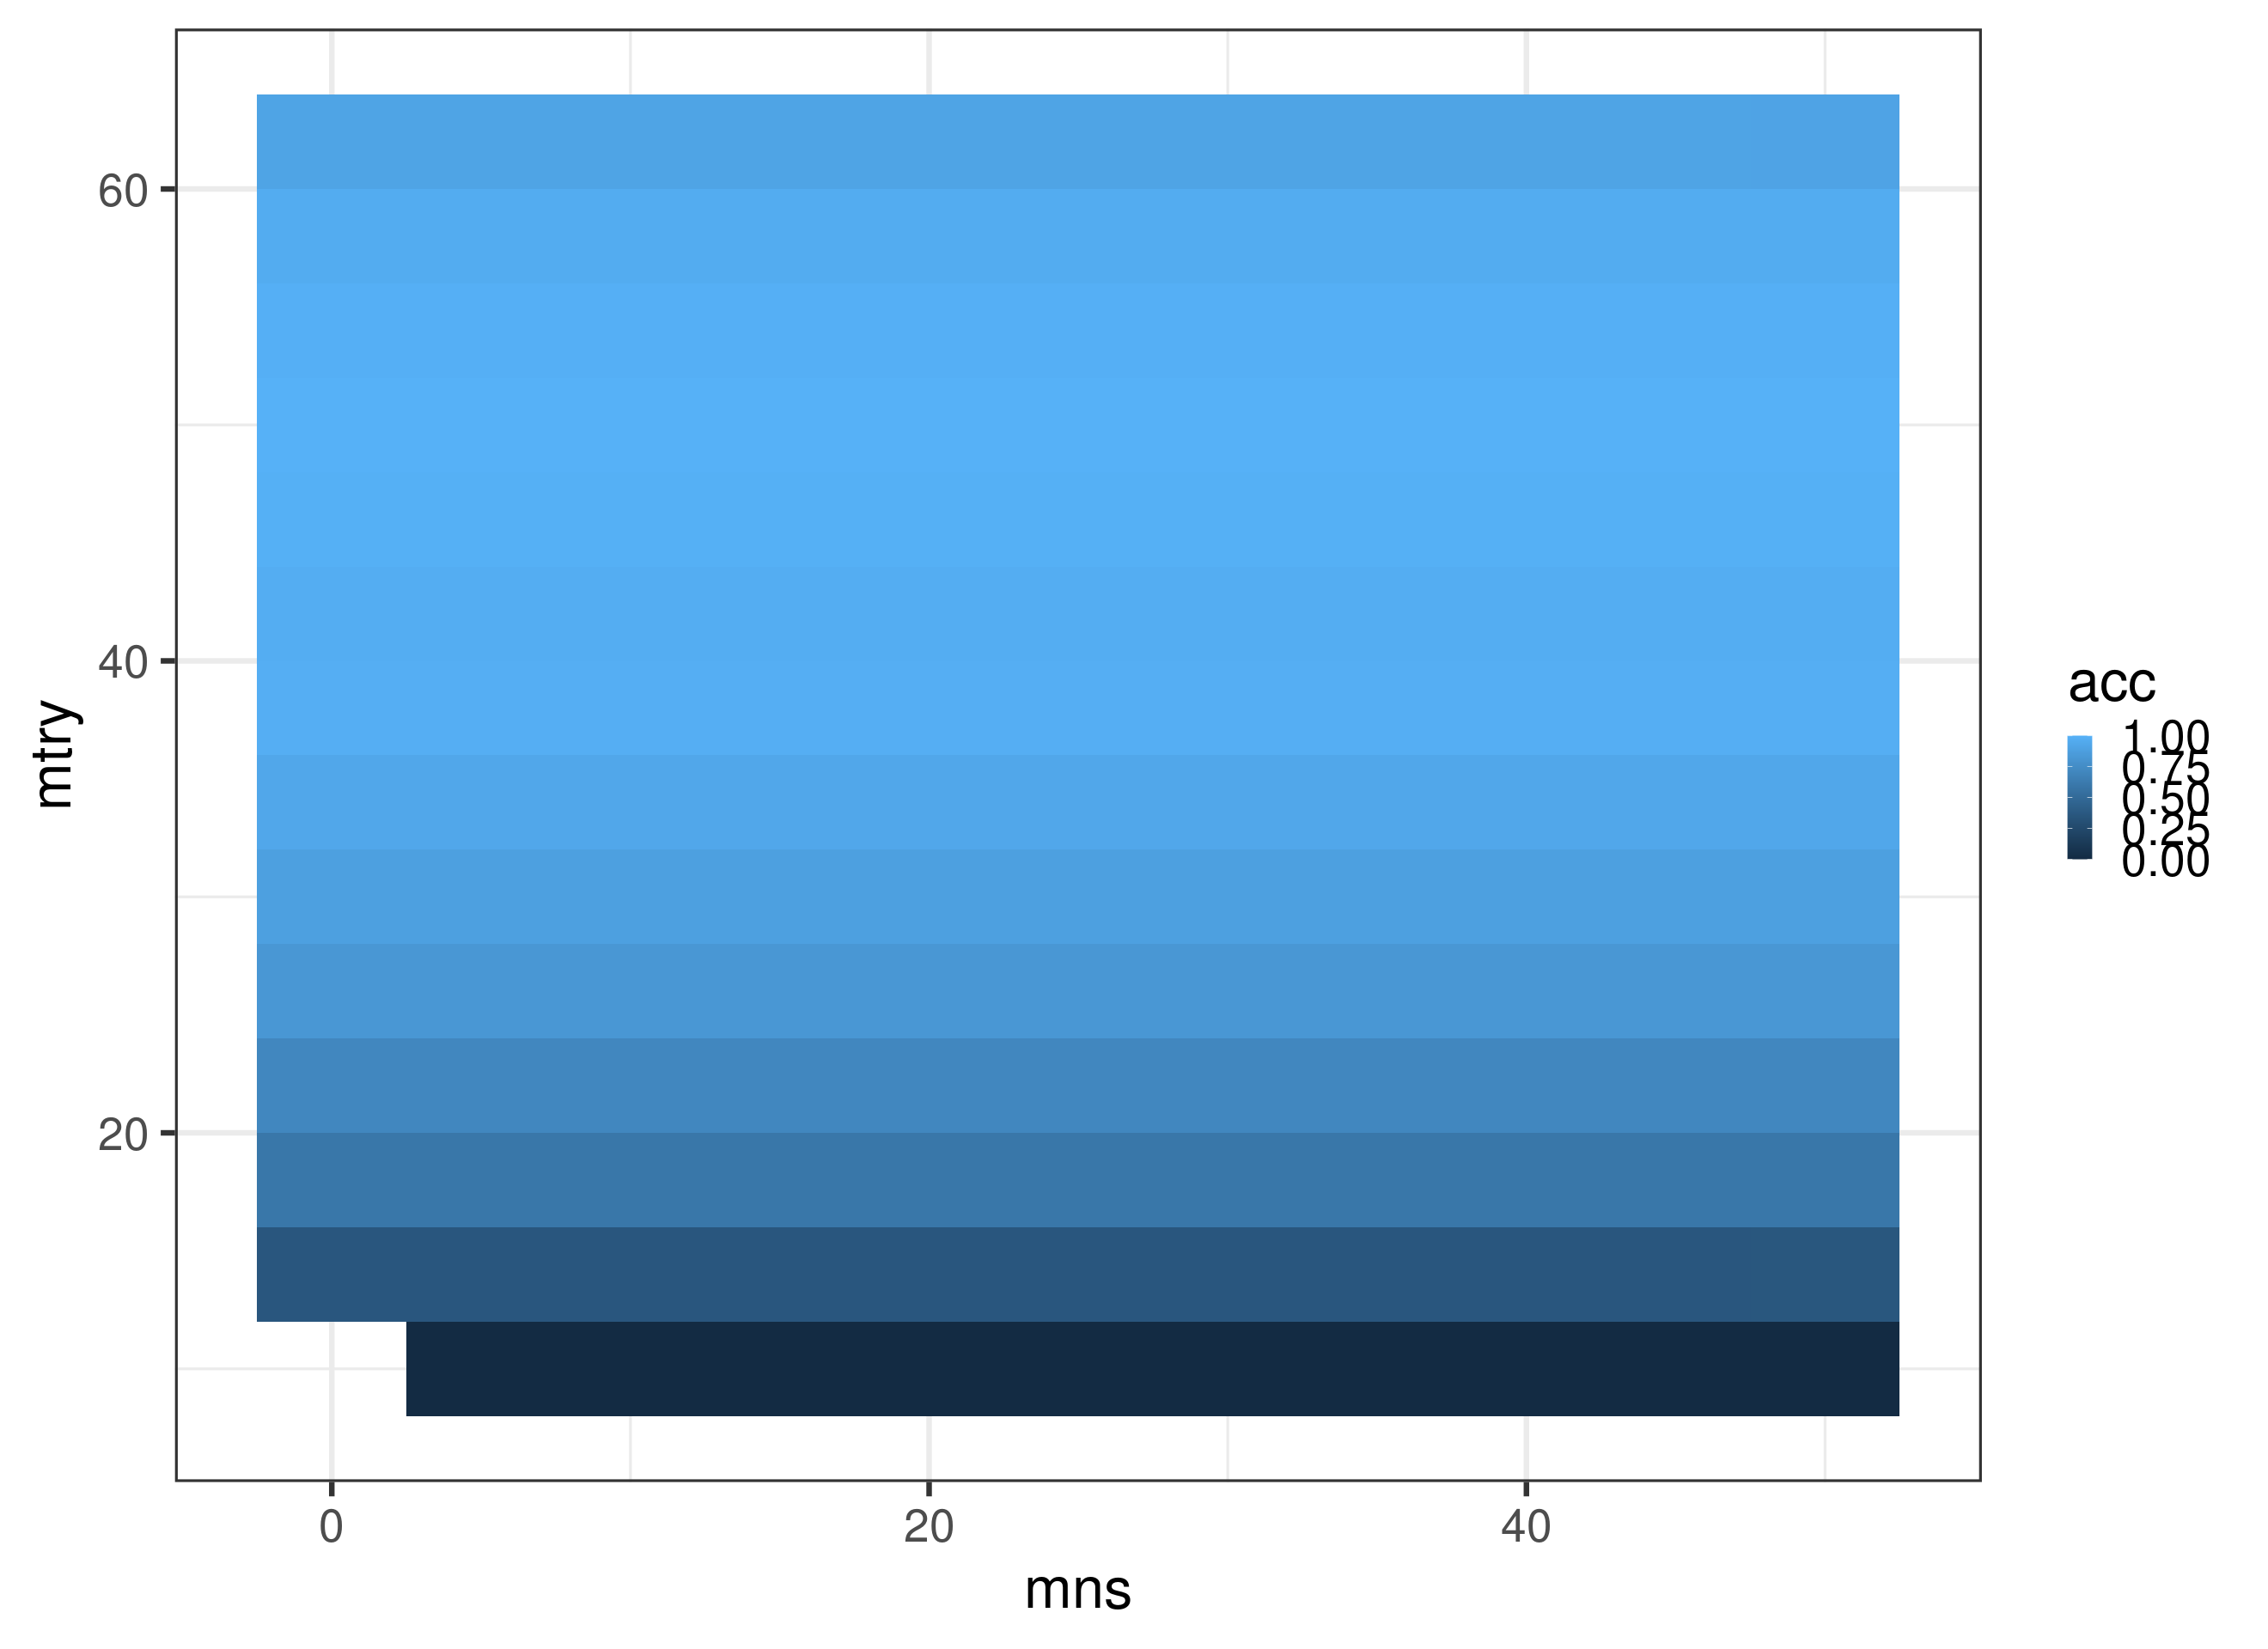

In [22]:
ggplot(p, aes(mns, mtry)) + geom_tile(aes(fill=acc)) + 
    theme(legend.text=element_text(size=25), axis.text.x = element_text(size=40), axis.text.y = element_text(size=40))  + theme_bw(base_size=40)

In [12]:
df_opendwarfs_abf <- read.csv("Data-Opendwarfs_on_devices/full_old_abff4149.csv")
df_opendwarfs_abf[is.na(df_opendwarfs_abf)] <- 0
df_opendwarfs_abf$application <- 0

In [13]:
set.seed(seeeed)

#use 20% of data for training
sampled_indices <- sample(seq_len(nrow(df_opendwarfs_abf)), size = round(nrow(df_opendwarfs_abf)*0.8))
train_set <- df_opendwarfs_abf[sampled_indices,]
test_set <- df_opendwarfs_abf[-sampled_indices,]

train_set = subset(train_set, select = -application)

print(trainModelGetAccuracy(train_set, test_set, 1000, 50, 50))
# trainModelGetAccuracySearch(train_set, test_set, 1000, mt_r, mns_r, rep_r, imp_r, srul_r)

Growing trees.. Progress: 89%. Estimated remaining time: 3 seconds.
[1] 98.5578


In [14]:
df_opendwarfs_abf <- read.csv("Data-Opendwarfs_on_devices/full_old_abff4149.csv")
df_opendwarfs_abf[is.na(df_opendwarfs_abf)] <- 0

In [15]:
options(warn=-1)

paramsTrees = data.frame(
                    trees=c(1),
                    acc=c(1))


sampled_indices <- sample(seq_len(nrow(df_opendwarfs_abf)), size = round(nrow(df_opendwarfs_abf)*0.8))
train_set <- df_opendwarfs_abf[sampled_indices,]
test_set <- df_opendwarfs_abf[-sampled_indices,]

# train_set = subset(train_set, select = -application)

for (ntrees in seq(500, 10000, 500)) {

    accracy = leaveOneKernelAccuracy(df_opendwarfs_abf, ntrees, 50, 50)

    param_stats = c(ntrees, mean(accracy))

    paramsTrees = rbind(paramsTrees, param_stats)
}

ERROR: Error in ranger(log(kernel_time) ~ ., data = train_dat, num.trees = nt, : User interrupt or internal error.


In [16]:
old_data <- read.csv("recompiledAIWCData.csv")

df_generated <- read.csv("Data-Generated_Kernels/gen_compiled_abff4149.csv")
df_opendwarfs <- read.csv("Data-Opendwarfs_on_devices/full_compiled_abff4149.csv")

df_opendwarfs = df_opendwarfs[!(df_opendwarfs['kernel'] == "cl_fdwt53Kernel"), ] 
df_opendwarfs = df_opendwarfs[!(df_opendwarfs['kernel'] == "c_CopySrcToComponents"), ] 

df_joined <- rbind(df_generated, df_opendwarfs)

# df_generated <- na.omit(df_generated)
# df_opendwarfs <- na.omit(df_opendwarfs)
# df_joined <- na.omit(df_joined)

df_generated[is.na(df_generated)] <- 0
df_opendwarfs[is.na(df_opendwarfs)] <- 0
df_joined[is.na(df_joined)] <- 0

In [17]:
length(unique(df_opendwarfs$kernel))

[1] 32

In [18]:
length(unique(df_generated$kernel))

[1] 64

In [19]:
# Pretend all the generated kernels are the same and name them 'CLgen Kernel'

kernals <- c()
for (k in df_joined$kernel) {
    if (nchar(k) > 40) {
        kernals <- c(kernals, "CLgen Kernel")
    }
    else {
        kernals <- c(kernals, k)
    }
}
df_joined$kernel <- kernals

<h2>Evaluation using generated kernels</h2>

Below we evaluate two models:
<ul>
    <li> Model trained using all of the Opendwarfs kernels 
    <li> Model trained using all of the Opendwarfs kernels + the generated kernels
</ul>

We evaluate both these models using 20% of the generated kernels and Opendwarfs kernels

We expect the second model to clearly perform better because the CLGen kernels are unseen to the first model; some of these generated kernels are part of the training set of the second model.

From below we can observe that this is indeed the case, the first model has a mean error of 1.228% and the second model has a mean error of 0.551% and from the graph we can tell that the first model is predicting very poorly on the CLgen kernels

In [20]:
set.seed(seeeed)

sampled_indices <- sample(seq_len(nrow(df_joined)), size = round(nrow(df_joined)*0.8))

train_set <- df_joined[sampled_indices,]
test_set <- df_joined[-sampled_indices,]


print("No generated Kernels:")
trainModelGetAccuracy(df_opendwarfs, test_set, 1000, 50, 50)

print("")
print("Generated Kernels:")
trainModelGetAccuracy(df_joined, test_set, 1000, 50, 50)

# plot_grid(fullTable, fullTableG, labels = "AUTO")

[1] "No generated Kernels:"


[1] 98.41053

[1] ""
[1] "Generated Kernels:"
Growing trees.. Progress: 98%. Estimated remaining time: 0 seconds.


[1] 99.07835

<h2>Evaluation on in-sample training data</h2>

Below we evaluate two models:
<ul>
    <li> Model trained using 80% of the Opendwarfs kernels 
    <li> Model trained using 80% of the Opendwarfs kernels + the generated kernels
</ul>
We evaluate them using:
<ul>
    <li> The other 20% of the Opendwarfs kernels 
    <li> The other 20% of the Opendwarfs kernels + the generated kernels
</ul>

Our expectation is that the second model still performs better - the idea is that the generated kernels provide a better coverage of the AIWC feature space allowing for better generalisation. 

From below we see that this is the case. Though there does not appear to be a particularly notable increase in performance for the Opendwarfs kernels from adding these generated kernels.

In [21]:
set.seed(seeeed)

sampled_indices <- sample(seq_len(nrow(df_opendwarfs)), size = round(nrow(df_opendwarfs)*0.8))
test_set <- df_opendwarfs[-sampled_indices,]
train_set <- df_opendwarfs[sampled_indices,]

print("No generated Kernels:")
# fullTable <- generateTable(train_set, test_set, TRUE, 100, 44, 0)
trainModelGetAccuracy(train_set, test_set, 1000, 50, 50)

set.seed(seeeed)

sampled_indices <- sample(seq_len(nrow(df_joined)), size = round(nrow(df_joined)*0.8))
test_set <- df_joined[-sampled_indices,]
train_set <- df_joined[sampled_indices,]

print("")
print("Generated Kernels:")
# fullTableG <- generateTable(train_set, test_set, TRUE, 100, 44, 0)
trainModelGetAccuracy(train_set,test_set, 1000, 50, 50)

# plot_grid(fullTable, fullTableG, labels = "AUTO")

[1] "No generated Kernels:"


[1] 98.87305

[1] ""
[1] "Generated Kernels:"
Growing trees.. Progress: 76%. Estimated remaining time: 9 seconds.


[1] 99.02185

<h1> Model comparison for accuracy on unseen kernels </h1>

We hypothesize that our new features provide a better coverage for the AIWC feature space, this shouldin turn lead to better generalisation and hence predictive accuracy on unseen kernels. 

We test this below and observe a mean improvement leave-on-out accuracy of ~0.4% from 86.796 to 87.193%. However the minimum and maximum predictions tend to be slightly worse when training with these new kernels.
    

In [23]:
l1 <- leaveOneKernelAccuracy(df_opendwarfs, 1000, 50, 50)

In [24]:
l2 <- leaveOneKernelAccuracy(df_joined, 1000, 50, 50)

Growing trees.. Progress: 97%. Estimated remaining time: 1 seconds.
Growing trees.. Progress: 98%. Estimated remaining time: 0 seconds.
Growing trees.. Progress: 96%. Estimated remaining time: 1 seconds.
Growing trees.. Progress: 97%. Estimated remaining time: 0 seconds.
Growing trees.. Progress: 98%. Estimated remaining time: 0 seconds.
Growing trees.. Progress: 98%. Estimated remaining time: 0 seconds.
Growing trees.. Progress: 98%. Estimated remaining time: 0 seconds.
Growing trees.. Progress: 97%. Estimated remaining time: 0 seconds.
Growing trees.. Progress: 98%. Estimated remaining time: 0 seconds.
Growing trees.. Progress: 98%. Estimated remaining time: 0 seconds.
Growing trees.. Progress: 98%. Estimated remaining time: 0 seconds.
Growing trees.. Progress: 99%. Estimated remaining time: 0 seconds.
Growing trees.. Progress: 99%. Estimated remaining time: 0 seconds.
Growing trees.. Progress: 97%. Estimated remaining time: 0 seconds.
Growing trees.. Progress: 98%. Estimated remaini

In [25]:
print(paste("Mean leave-one-out accuracy on unseen kernel using no generated kernels:", mean(l1)))
print(paste("Mean leave-one-out accuracy on unseen kernel using generated kernels:", mean(l2)))
print(paste("Mean leave-one-out accuracy on unseen kernel using generated kernels (excluding generated kernels):", mean(tail(l2, length(l2)-1))))

print("")
print(paste("Minimum leave-one-out accuracy on unseen kernel using no generated kernels:", min(l1)))
print(paste("Minimum leave-one-out accuracy on unseen kernel using generated kernels:", min(l2)))

print("")
print(paste("Maximum leave-one-out accuracy on unseen kernel using no generated kernels:", max(l1)))
print(paste("Maximum leave-one-out accuracy on unseen kernel using generated kernels:", max(l2)))

[1] "Mean leave-one-out accuracy on unseen kernel using no generated kernels: 86.8638999514554"
[1] "Mean leave-one-out accuracy on unseen kernel using generated kernels: 87.307897913971"
[1] "Mean leave-one-out accuracy on unseen kernel using generated kernels (excluding generated kernels): 87.4583920528436"
[1] ""
[1] "Minimum leave-one-out accuracy on unseen kernel using no generated kernels: 53.4605208874356"
[1] "Minimum leave-one-out accuracy on unseen kernel using generated kernels: 68.0698358063257"
[1] ""
[1] "Maximum leave-one-out accuracy on unseen kernel using no generated kernels: 98.8118693303591"
[1] "Maximum leave-one-out accuracy on unseen kernel using generated kernels: 98.2909755381123"


No id variables; using all as measure variables

Saving 6.67 x 6.67 in image



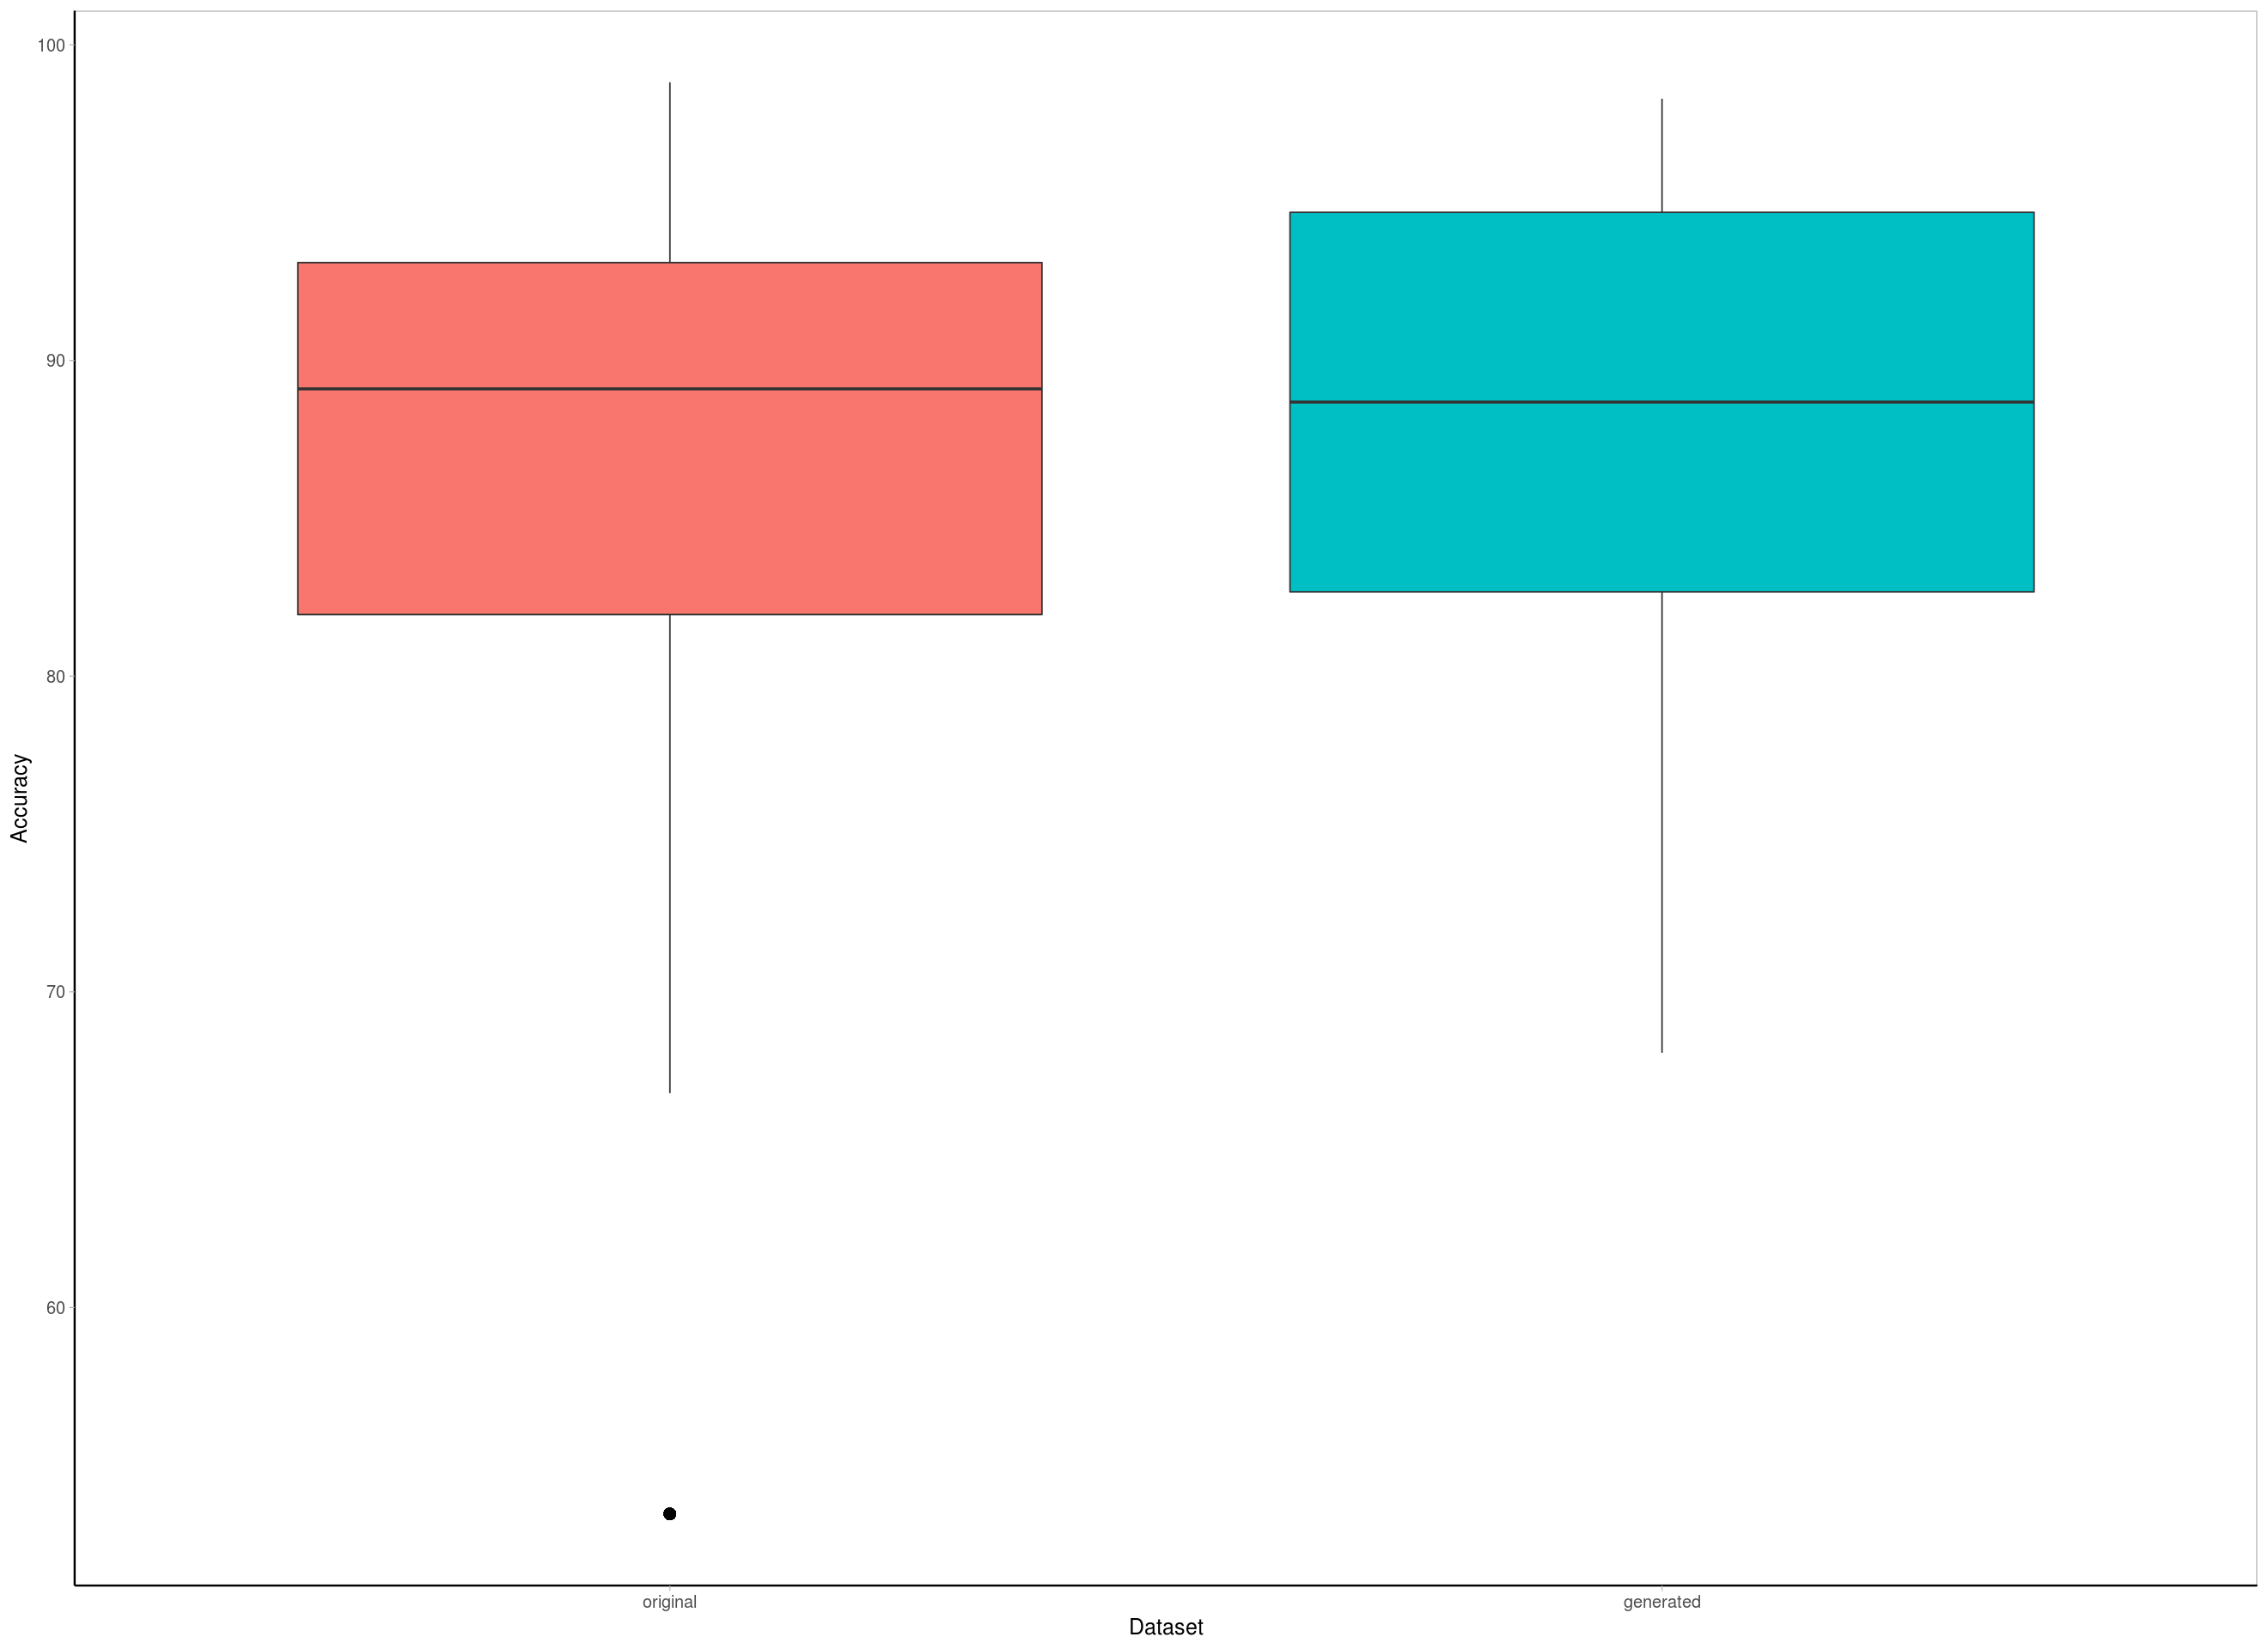

In [50]:
d1 <- data.frame(original = l1,
                 generated = tail(l2, length(l1)))

d2<-melt(d1)
d2$accuracy <- d2$value


bplot1 <- ggplot(data = d2, aes(x=variable, y=accuracy, fill=variable)) + geom_boxplot(outlier.colour="black", outlier.shape=16,outlier.size=4, notch=FALSE) + theme_light(base_size=15) + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.line = element_line(colour = "black")) +
    theme(legend.position = "none")  + 
    labs(y = 'Accuracy', x = "Dataset")

ggsave(filename="/workspace/bplot1.pdf", plot=bplot1)

bplot1

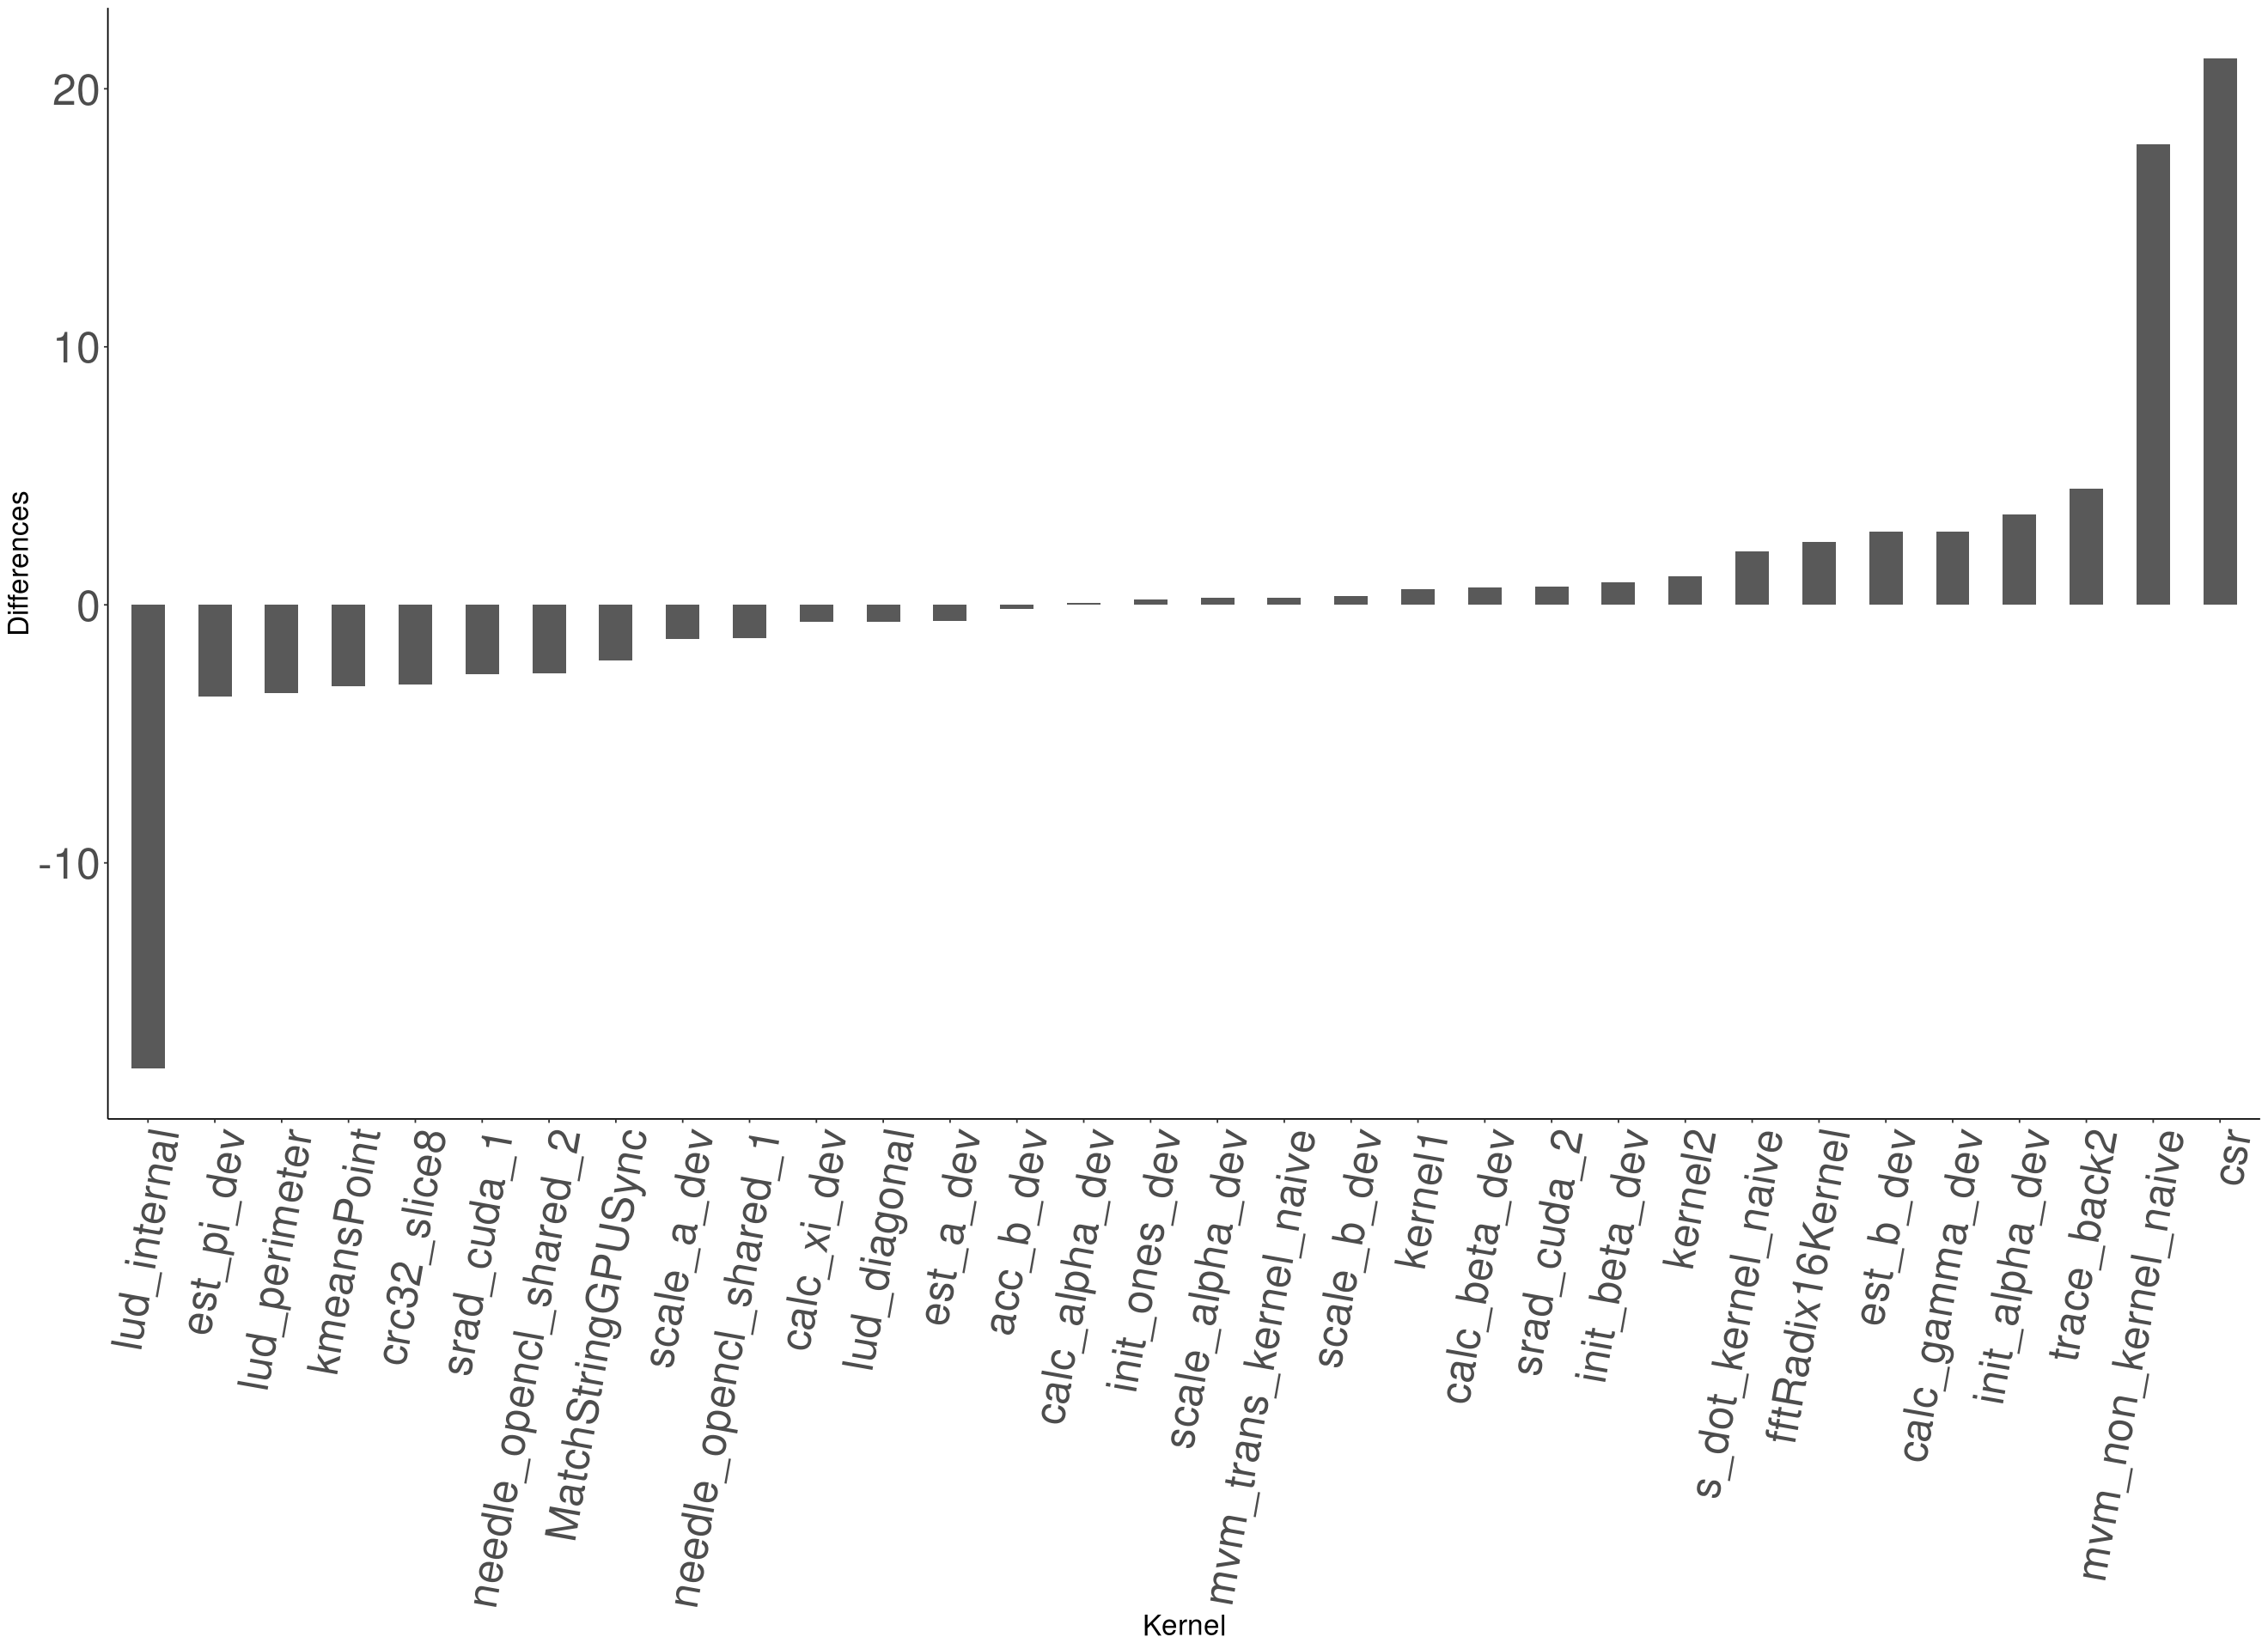

In [27]:
differences <- data.frame(Kernel = unique(df_opendwarfs$kernel),
                          Differences = tail(l2, length(l2)-1) - l1)

differences <- differences[order(differences$Differences), ]
rownames(differences) <- NULL
differences$Kernel = factor(differences$Kernel, levels = differences$Kernel[order(differences$Differences)])

ggplot(data = differences, aes(x = Kernel, y=Differences)) +
  geom_bar(stat="identity", width=0.5) +
  theme(text = element_text(size=20),axis.text.y = element_text(size=30),axis.text.x=element_text(angle=80,hjust=1, size=30)) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.line = element_line(colour = "black"))

Saving 6.67 x 6.67 in image



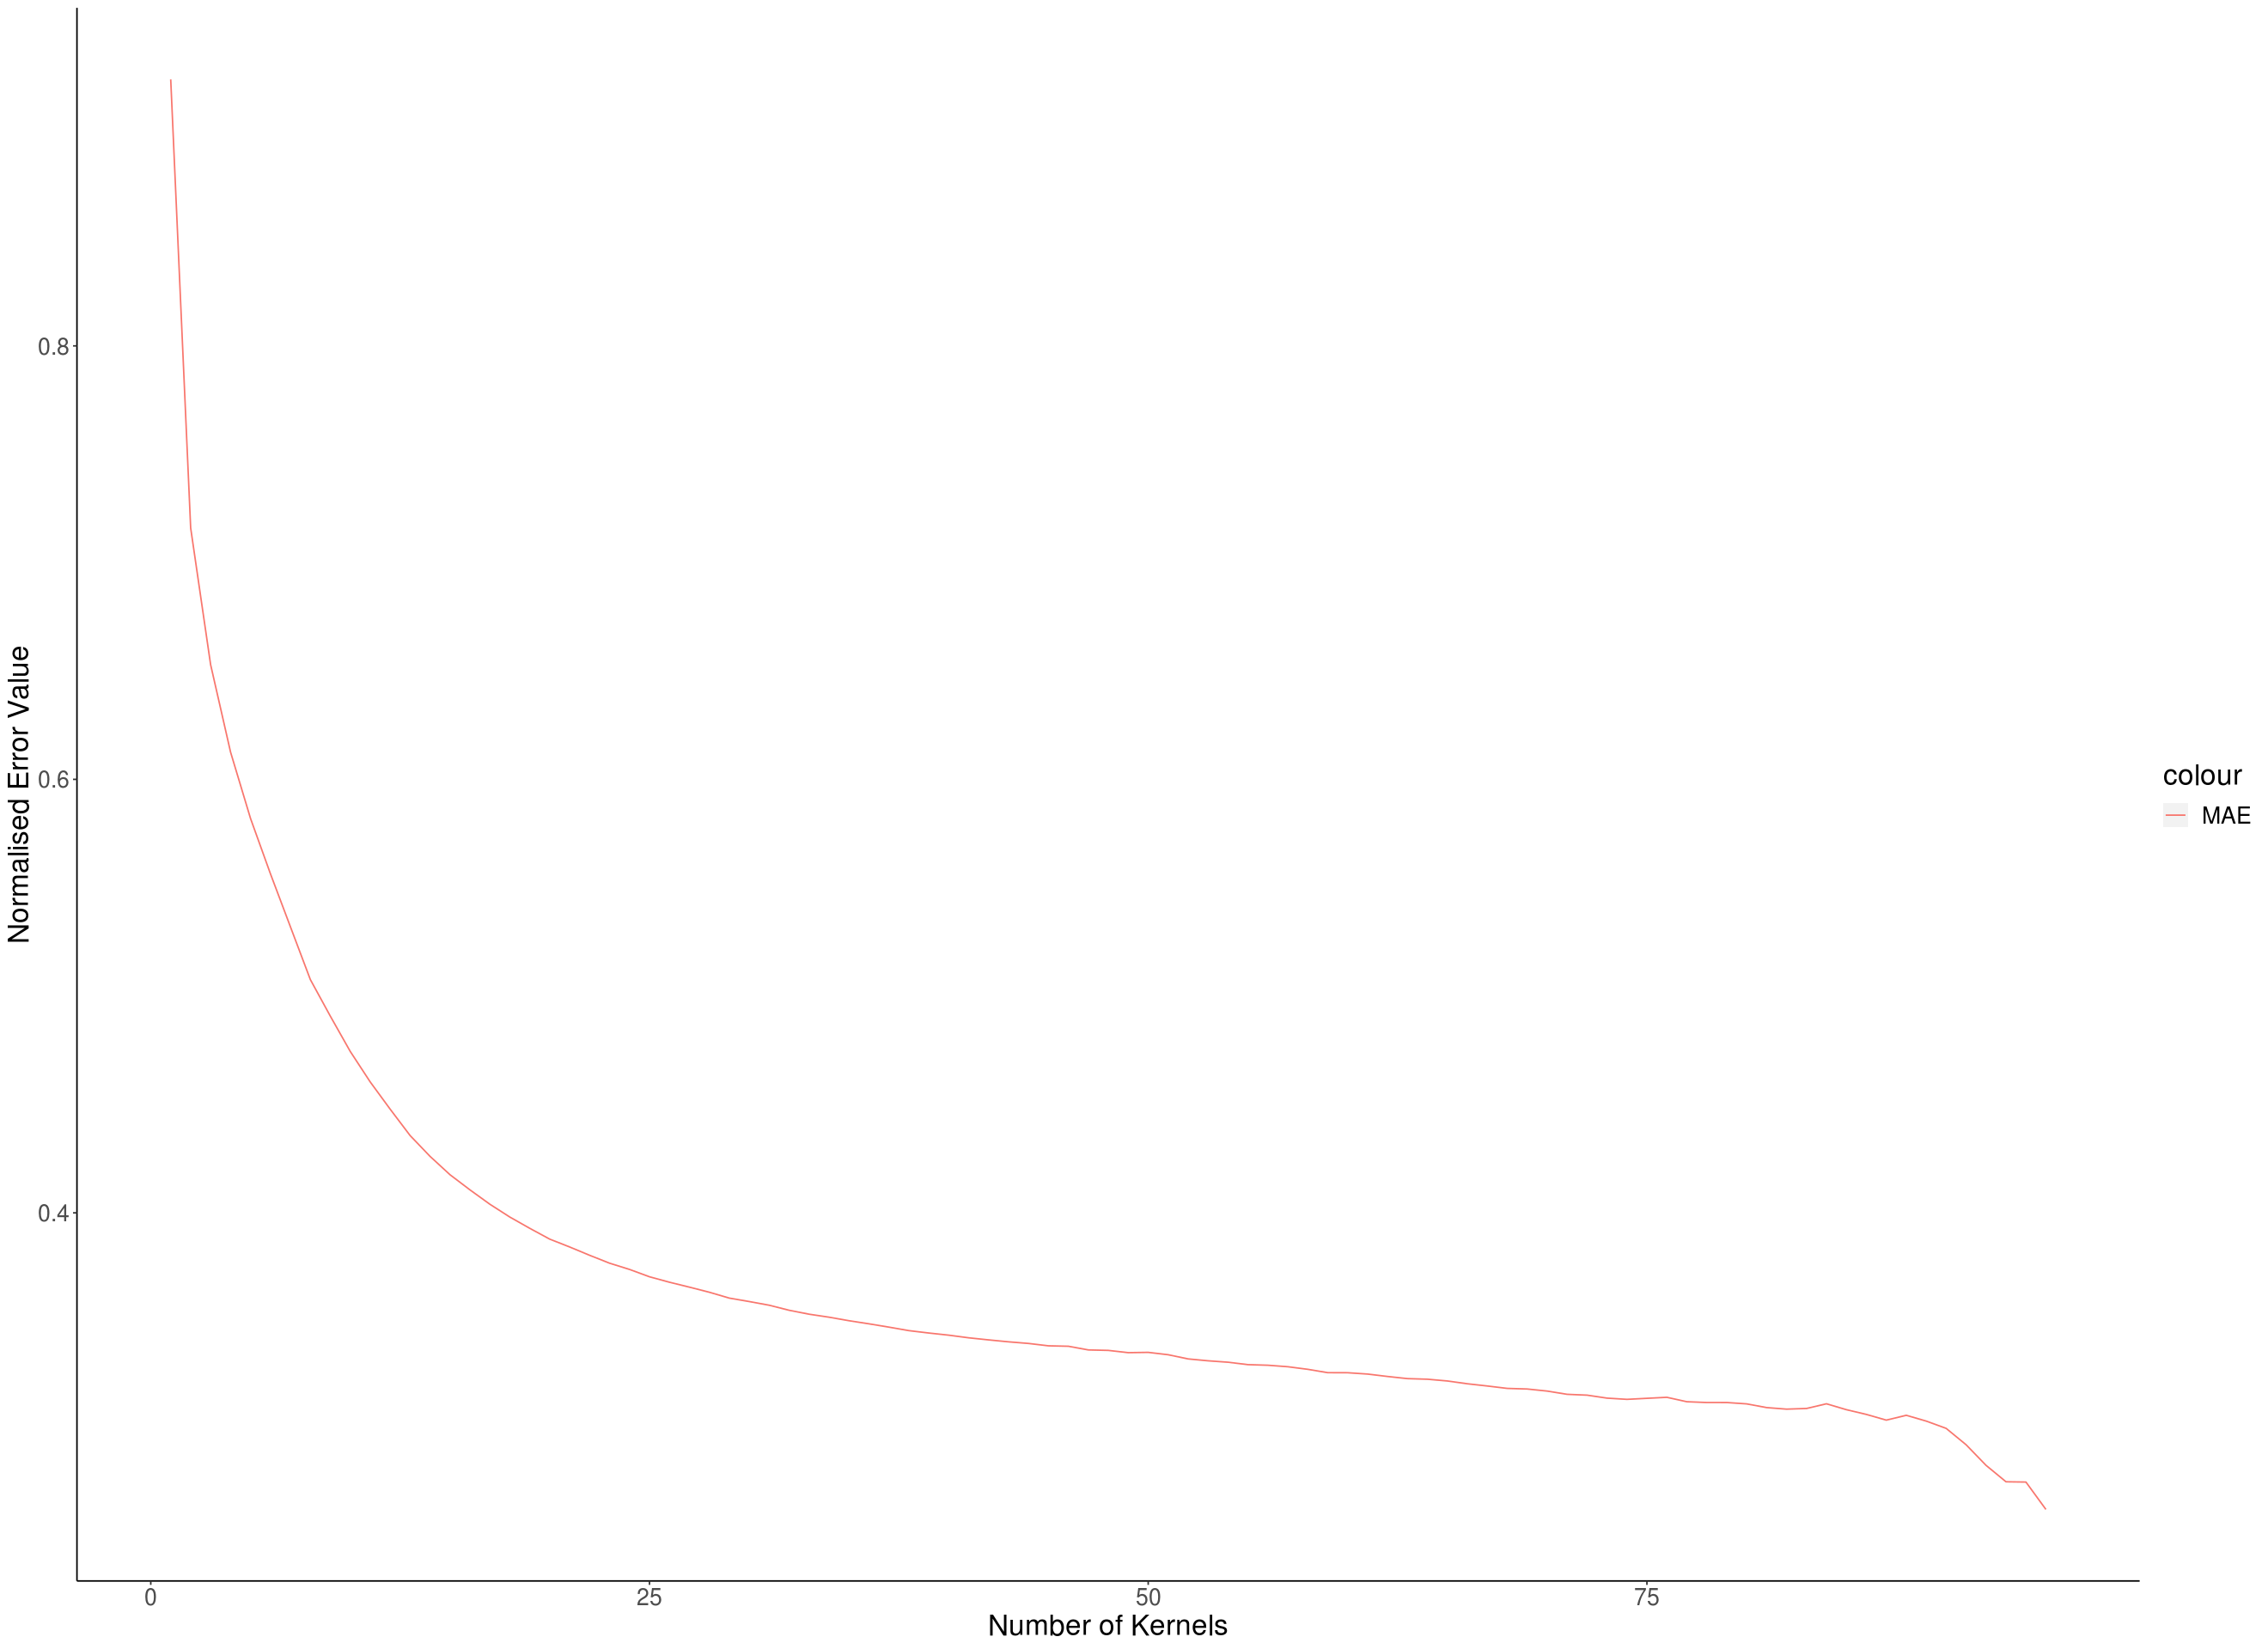

In [52]:
loss_curve <- read.csv("Data-Loss_curves/full_joined.csv")

normalisedcurve <- loss_curve
# normalisedcurve$Mean_Absolute_Error <- normalisedcurve$mseloss / max(normalisedcurve$mseloss)
# normalisedcurve$Accuracy <- normalisedcurve$accloss / max(normalisedcurve$accloss)

loo <- ggplot(normalisedcurve, aes(no_kernels)) +
  geom_line(aes(y = mseloss, colour = "MAE")) + 
#   geom_line(aes(y = Accuracy, colour = "Accuracy")) + 
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.line = element_line(colour = "black")) +
  labs(y = 'Normalised Error Value', x = "Number of Kernels")

ggsave(filename="/workspace/loss_curve.pdf", plot=loo)

loo

## Device predictions

In [35]:
set.seed(seeeed)

tr_dat <- df_joined
tr_dat = subset(tr_dat, select = -size)
tr_dat = subset(tr_dat, select = -kernel)
tr_dat = subset(tr_dat, select = -total_time)

rgd.aiwc <- ranger(log(kernel_time)~.,
               data = tr_dat,
               num.trees = 1000,
               mtry = 50,
               min.node.size = 50,
               importance = "impurity",
               splitrule = 'variance',
               respect.unordered.factors = 'order')

#make the predictions
rgd.pred <- predict(rgd.aiwc,type='response',data=df_opendwarfs)


Growing trees.. Progress: 97%. Estimated remaining time: 1 seconds.


In [36]:
set.seed(seeeed)

tr_dat <- df_opendwarfs
tr_dat = subset(tr_dat, select = -size)
tr_dat = subset(tr_dat, select = -kernel)
tr_dat = subset(tr_dat, select = -total_time)

rgd.aiwc <- ranger(log(kernel_time)~.,
               data = tr_dat,
               num.trees = 1000,
               mtry = 50,
               min.node.size = 50,
               importance = "impurity",
               splitrule = 'variance',
               respect.unordered.factors = 'order')

#make the predictions
rgd.pred1 <- predict(rgd.aiwc,type='response',data=df_opendwarfs)


In [37]:
dframe <- data.frame(generated = rgd.pred$predictions,
                     opendwarfs = rgd.pred1$predictions,
                     actual = log(df_opendwarfs$kernel_time),
                     kernel = df_opendwarfs$kernel,
                     sizes = df_opendwarfs$size,
                     device = df_opendwarfs$device)

Using kernel as id variables

Saving 6.67 x 6.67 in image



[1] 0.02417155

[1] 0.02614296

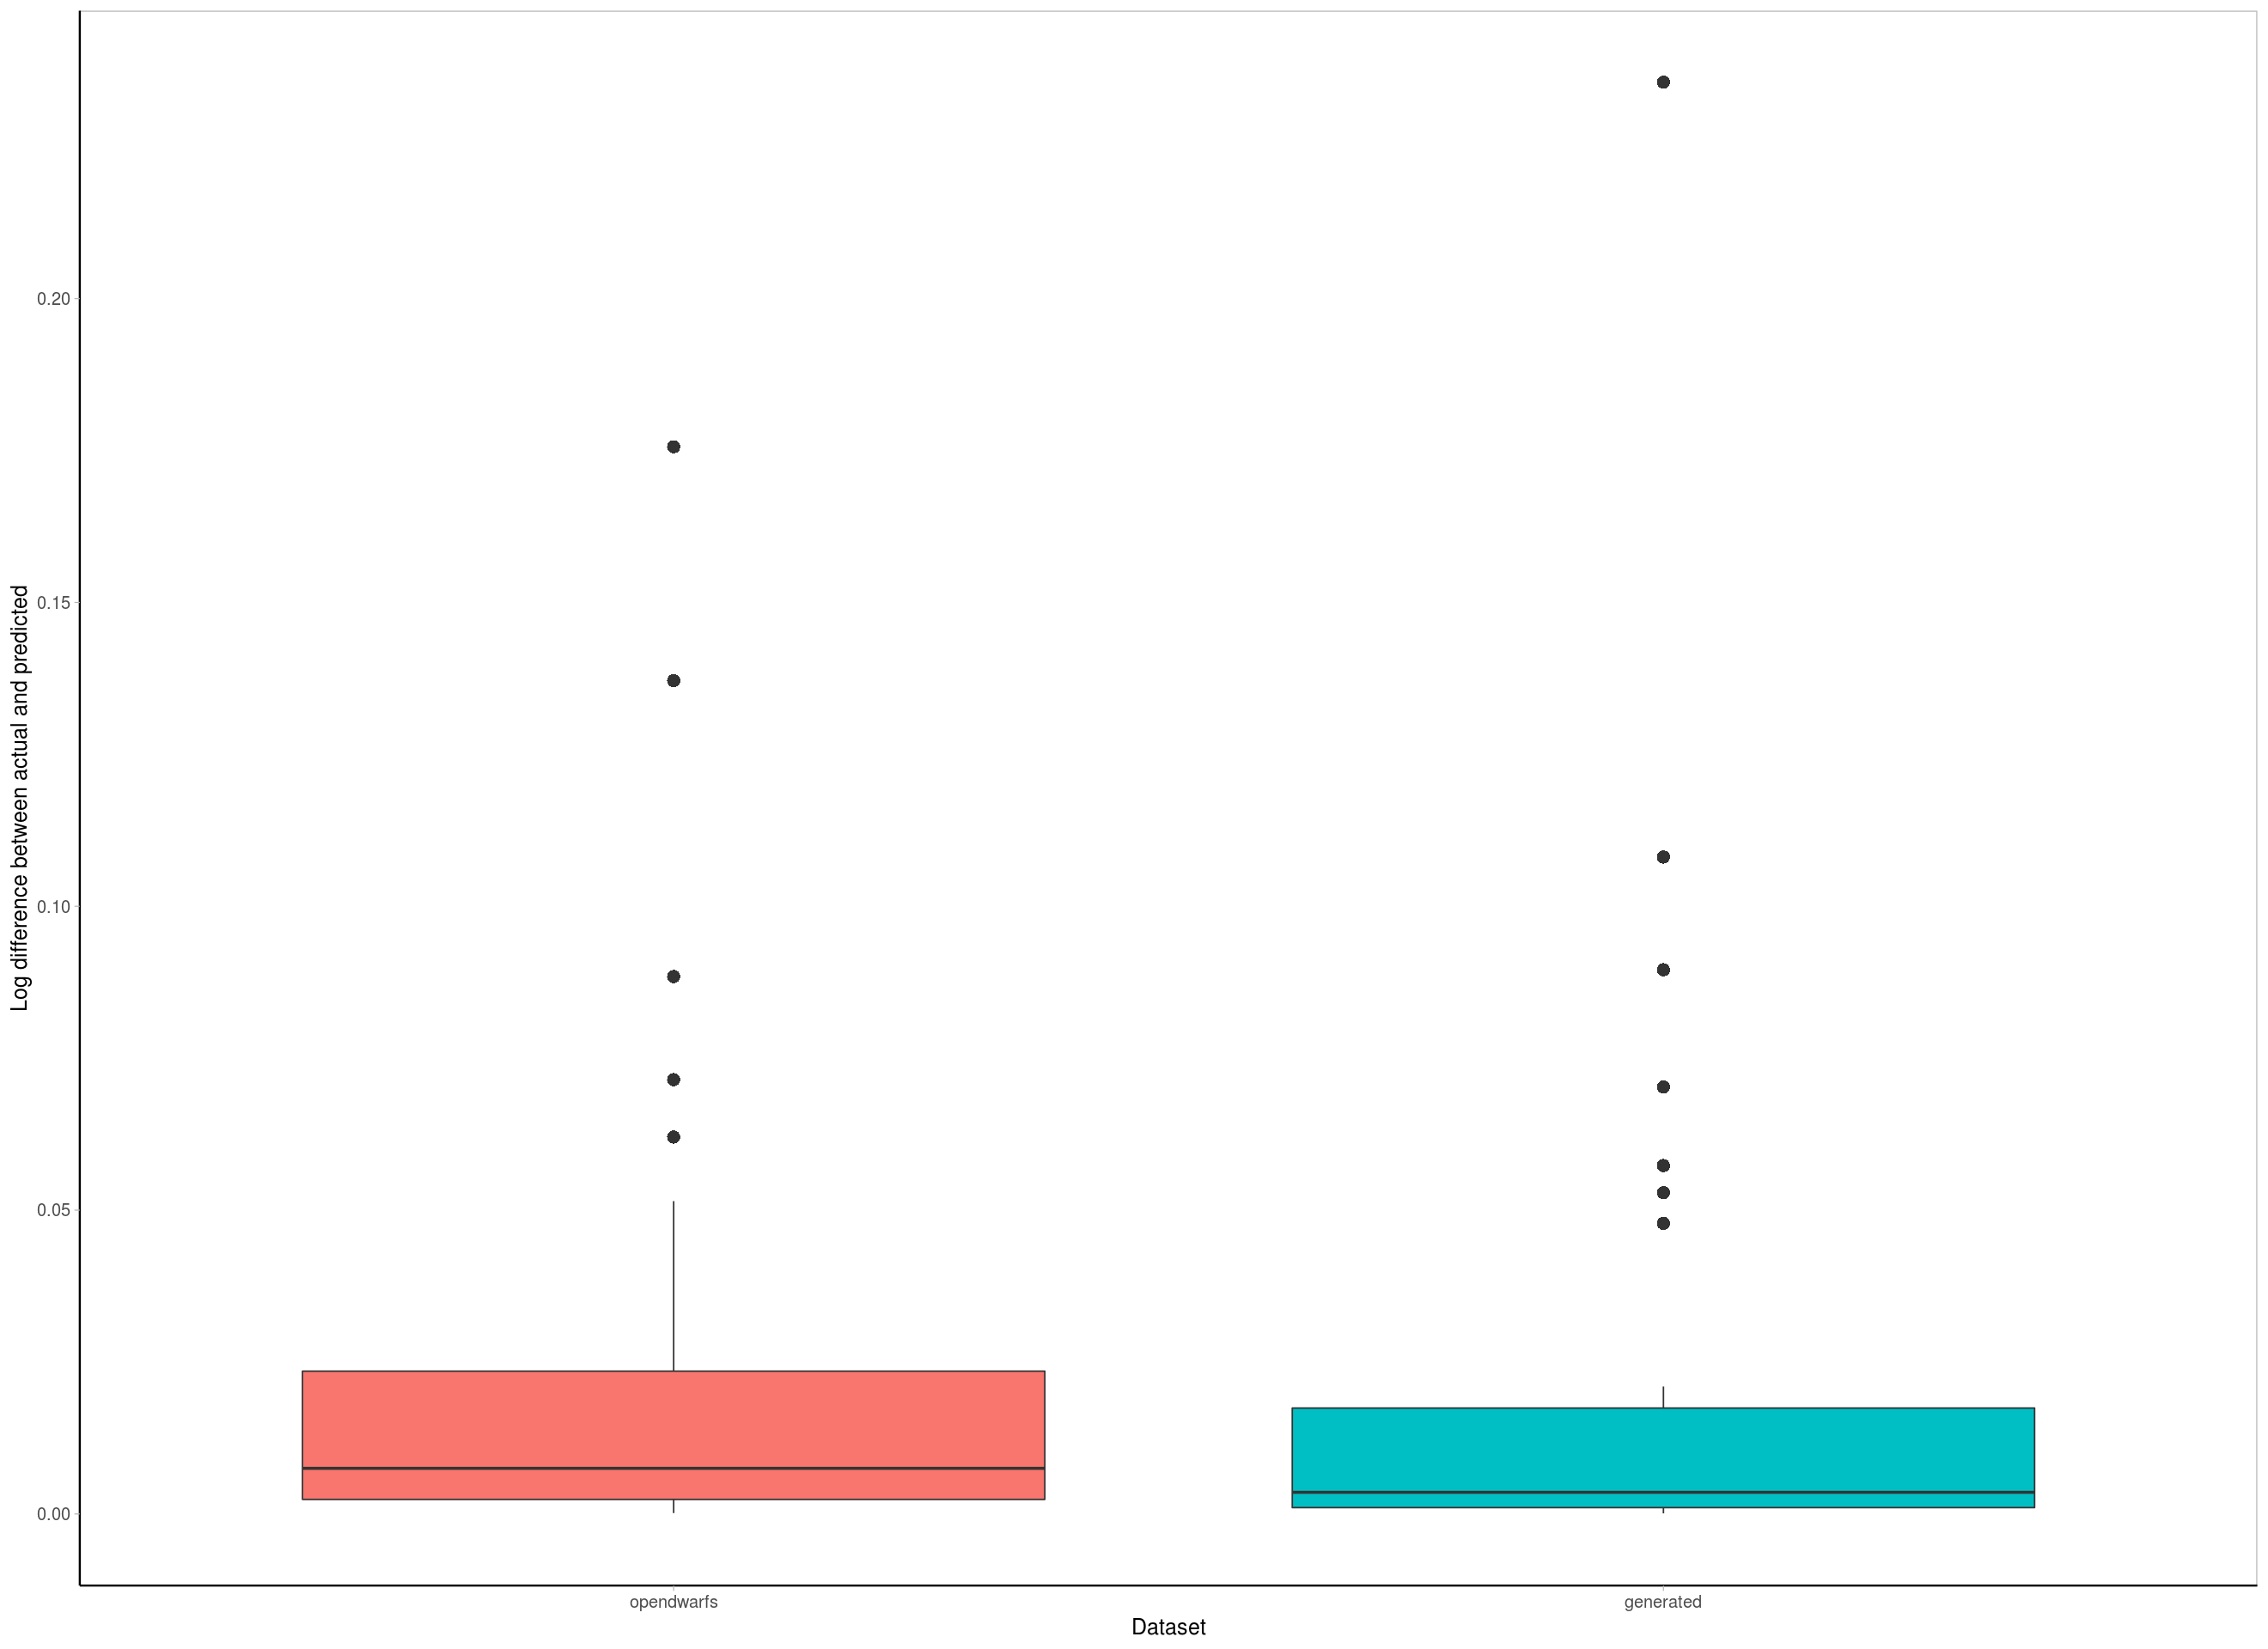

In [329]:
diffFrame = data.frame(opendwarfs = c(),
                       generated  = c(),
                       kernel     = c())

for (kern in unique(df_opendwarfs$kernel)) {
    d1 = dframe[dframe$kernel %in% kern & dframe$size %in% 'small', ]
    
    ddat = data.frame(device = c(),
                      actual = c(),
                      opendwarfs = c(),
                      generated = c())

    for (d in unique(dframe$device)) {
        a <- (mean(d1[d1$device %in% d, ]$actual))
        g <- (mean(d1[d1$device %in% d, ]$generated))
        o <- (mean(d1[d1$device %in% d, ]$opendwarfs))

        roww <- data.frame(device = d, actual = a, opendwarfs = o, generated = g)

        ddat <- rbind(ddat, roww)
    }

    ddat$actual <- sapply(ddat$actual, as.numeric)
    ddat$opendwarfs <- sapply(ddat$opendwarfs, as.numeric)
    ddat$generated <- sapply(ddat$generated, as.numeric)

    gendiff = abs(ddat$actual[order(ddat$actual)[1]] - ddat$generated[order(ddat$generated)[1]])
    opediff = abs(ddat$actual[order(ddat$actual)[1]] - ddat$opendwarfs[order(ddat$opendwarfs)[1]])
    
    tempdiffframe = data.frame(opendwarfs = opediff, generated = gendiff, kernel = kern)
    diffFrame = rbind(tempdiffframe, diffFrame)
}

meldiframe = melt(diffFrame)

a<- ggplot(data = meldiframe, aes(x=variable, y=value, fill=variable)) +
    geom_boxplot(utlier.colour="black", outlier.shape=16,outlier.size=4, notch=FALSE) + 
    theme_light(base_size=15) + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.line = element_line(colour = "black")) +
    ylab("Log difference between actual and predicted") +
    ylim(0, max(meldiframe$value)) + 
    xlab("Dataset") +
    theme(legend.position = "none") 

ggsave(filename="/workspace/smallsizes.pdf", plot=a)

mean(na.omit(diffFrame$generated))
mean(na.omit(diffFrame$opendwarfs))

a

In [328]:
diffFrame

opendwarfs,generated,kernel
<dbl>,<dbl>,<fct>
0.1756172907,1.080994e-01,trace_back2
0.0064054939,5.733378e-02,MatchStringGPUSync
0.0714664931,2.235348e-03,init_alpha_dev
0.0620269872,7.026911e-02,init_beta_dev
0.0034987071,9.441558e-05,scale_b_dev
0.0432736663,8.495645e-04,init_ones_dev
0.0018659637,6.037487e-04,lud_diagonal
0.0071083213,9.669472e-03,est_a_dev
0.0028559349,2.055829e-03,est_b_dev


In [324]:
diffFrame = data.frame(opendwarfs = c(),
                       generated  = c(),
                       kernel     = c(),
                       device     = c(),
                       kernel     = c())

smallFrame = dframe[dframe$sizes %in% 'small', ]
for (kern in unique(smallFrame$kernel)) {
    if (kern == 'trace_back2' | kern == "MatchStringGPUSync") {
        next
    }
    
    d1 = smallFrame[smallFrame$kernel %in% kern, ]

    for (d in unique(smallFrame$device)) {
        a <- (mean(d1[d1$device %in% d, ]$actual))
        g <- (mean(d1[d1$device %in% d, ]$generated))
        o <- (mean(d1[d1$device %in% d, ]$opendwarfs))

        rrow = data.frame(device = d,
                          actual = a,
                          opendwarfs = o,
                          generated = g,
                          kernel = kern)
        
        diffFrame <- rbind(diffFrame, rrow)
    }
}

kernelsInterest = c('init_alpha_dev', 'lud_diagonal', 'srad_cuda_2', 'kmeansPoint')
intframe <- diffFrame[diffFrame$kernel %in% kernelsInterest, ]

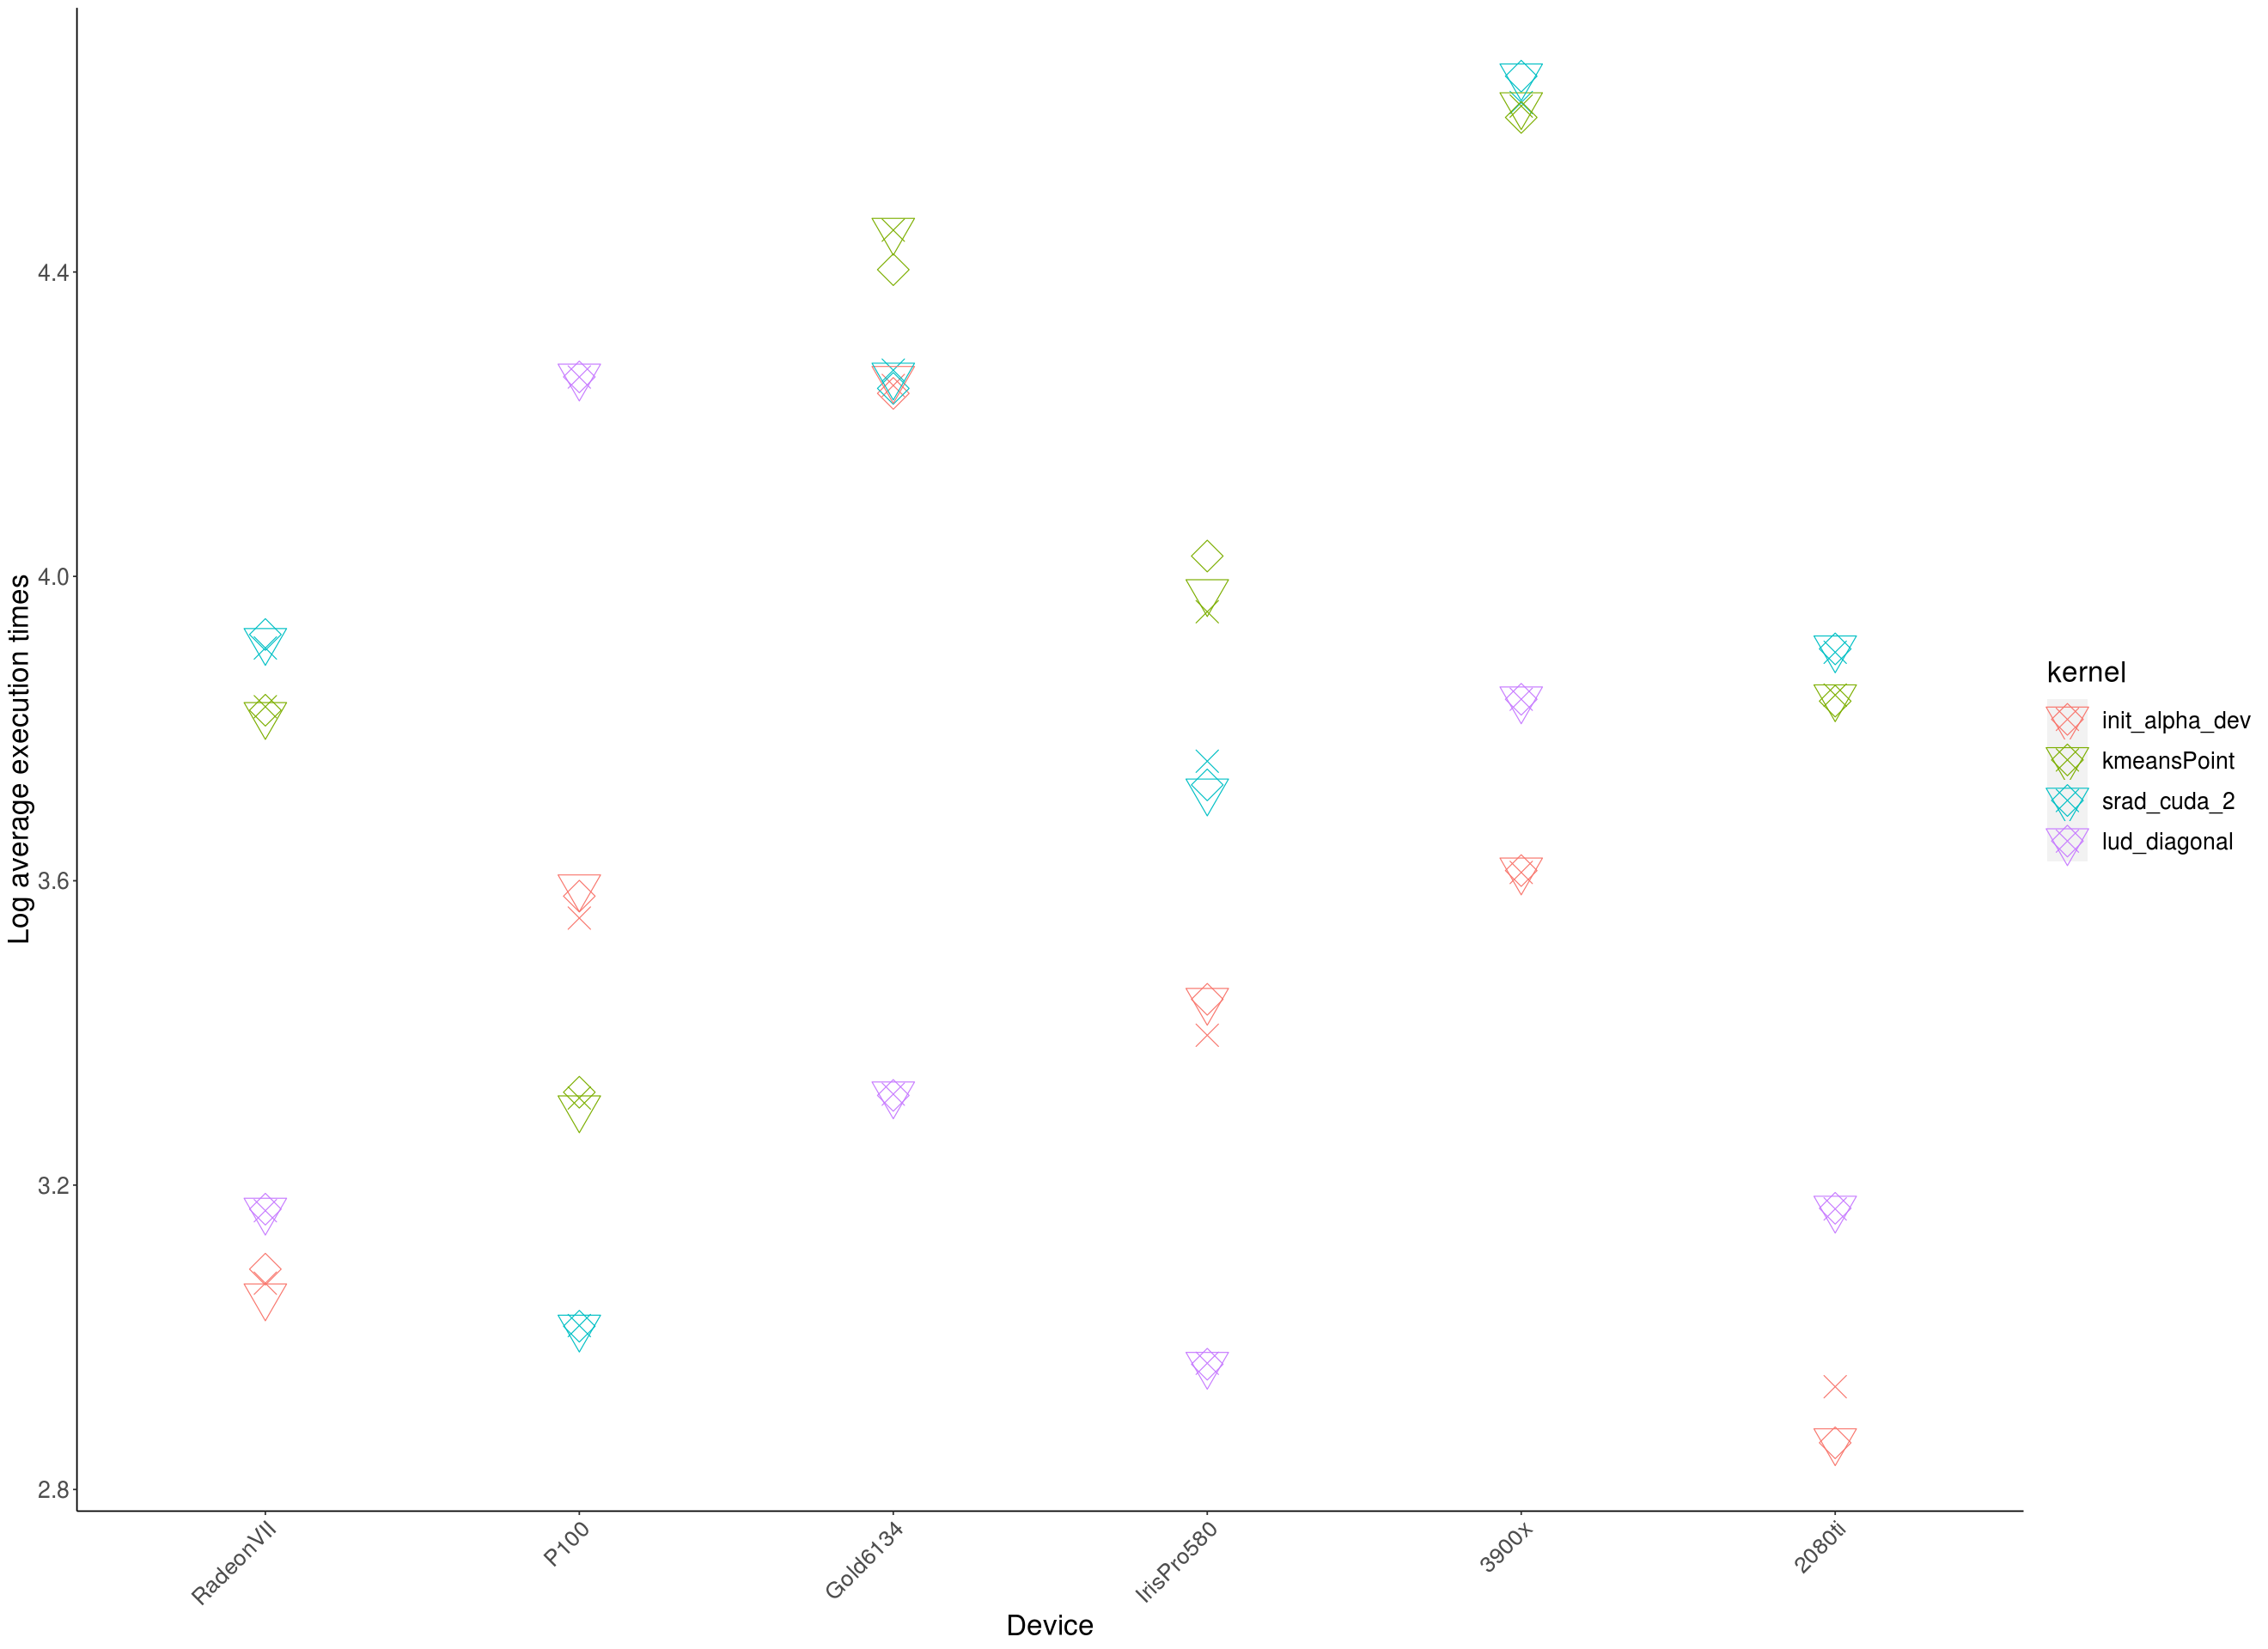

In [325]:
p <- ggplot(intframe,aes(x=device,y=generated,colour=kernel)) +
    geom_point(aes(x=device,y=opendwarfs,colour=kernel), shape=4, size=7) +
    geom_point(aes(x=device,y=generated,colour=kernel), shape=5, size=7) +
    geom_point(aes(x=device,y=actual,colour=kernel), shape=6, size=10) +
    theme(axis.text.x=element_text(angle=45,hjust=1)) + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), axis.line = element_line(colour = "black")) +
    ylab("Log average execution times") +
    xlab("Device")
ggsave(filename="/workspace/motivation.pdf", plot=p, scale=1, width=15, height=10)
p